In [89]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Path to trace data directory
trace_dir = './results_store/_final/trace/slownet/'

# Helper function to parse trace logs and extract timing information
def parse_trace_log(log_file):
    """Parse trace log file and extract operation timings"""
    timings = []
    operations = []
    
    # Track requests to match with their completion timings
    pending_requests = {}
    
    with open(log_file, 'r') as f:
        for line in f:
            # Extract timestamp and operation type
            if 'PUT request received' in line:
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                key_match = re.search(r'key: ([^\\s]+)', line)
                if timestamp_match and key_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    key = key_match.group(1)
                    operations.append({
                        'timestamp': timestamp,
                        'operation': 'PUT_REQUEST',
                        'type': 'request_start',
                        'key': key
                    })
                    pending_requests[key] = {'start_time': timestamp, 'type': 'PUT'}
                    
            elif 'GET request received' in line:
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                key_match = re.search(r'key: ([^\\s]+)', line)
                if timestamp_match and key_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    key = key_match.group(1)
                    operations.append({
                        'timestamp': timestamp,
                        'operation': 'GET_REQUEST',
                        'type': 'request_start',
                        'key': key
                    })
                    pending_requests[key] = {'start_time': timestamp, 'type': 'GET'}
                    
            elif 'time.busy=' in line and 'time.idle=' in line:
                # Extract timing information
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                busy_match = re.search(r'time\.busy=([0-9.]+[µμmns]*)', line)
                idle_match = re.search(r'time\.idle=([0-9.]+[µμmns]*)', line)
                
                if timestamp_match and busy_match and idle_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    busy_time = parse_time_value(busy_match.group(1))
                    idle_time = parse_time_value(idle_match.group(1))
                    
                    # Determine operation type from context and file path
                    operation_type = 'UNKNOWN'
                    operation_layer = 'UNKNOWN'
                    
                    # Determine the operation layer
                    if '_memory_store.rs' in line:
                        operation_layer = 'MEMORY_STORE'
                    elif '_persistent_store.rs' in line:
                        operation_layer = 'PERSISTENT_STORE'
                    elif 'http_put:' in line:
                        operation_layer = 'HTTP_PUT'
                    elif 'http_get:' in line:
                        operation_layer = 'HTTP_GET'
                    elif 'send_omnipaxos_request:' in line:
                        operation_layer = 'OMNIPAXOS_REQUEST'
                    
                    # Determine operation type
                    if 'set:' in line:
                        operation_type = 'SET'
                    elif 'get:' in line:
                        operation_type = 'GET'
                    elif 'http_put:' in line:
                        operation_type = 'HTTP_PUT'
                    elif 'http_get:' in line:
                        operation_type = 'HTTP_GET'
                    elif 'send_omnipaxos_request:' in line:
                        operation_type = 'OMNIPAXOS_REQUEST'
                    
                    # Combine operation type and layer for better analysis
                    combined_operation = f"{operation_type}_{operation_layer}" if operation_layer != 'UNKNOWN' else operation_type
                    
                    timings.append({
                        'timestamp': timestamp,
                        'operation': combined_operation,
                        'operation_type': operation_type,
                        'operation_layer': operation_layer,
                        'busy_time_ms': busy_time,
                        'idle_time_ms': idle_time,
                        'total_time_ms': busy_time + idle_time,
                        'log_line': line.strip()[:200]  # Store truncated line for debugging
                    })
    
    return pd.DataFrame(timings), pd.DataFrame(operations)

def parse_time_value(time_str):
    """Convert time string to milliseconds"""
    time_str = time_str.strip()
    
    if 'µs' in time_str or 'μs' in time_str:
        return float(time_str.replace('µs', '').replace('μs', '')) / 1000
    elif 'ms' in time_str:
        return float(time_str.replace('ms', ''))
    elif time_str.endswith('m') and not time_str.endswith('ms'):
        # Handle minutes
        return float(time_str.replace('m', '')) * 60 * 1000
    elif time_str.endswith('s') and not time_str.endswith('µs') and not time_str.endswith('μs') and not time_str.endswith('ms'):
        # Handle seconds (but not microseconds or milliseconds)
        return float(time_str.replace('s', '')) * 1000
    else:
        # Try to parse as number - assume microseconds if no unit
        try:
            return float(time_str) / 1000
        except ValueError:
            # If parsing fails, return 0 and print warning
            print(f"Warning: Could not parse time value: {time_str}")
            return 0.0

def get_system_type_from_logs(log_file):
    """Determine if this is an erasure or replication system from log content"""
    with open(log_file, 'r') as f:
        first_100_lines = [f.readline() for _ in range(100)]
    
    # Check for erasure coding indicators
    erasure_indicators = ['src/ec/']
    replication_indicators = ['src/standard/']
    
    content = ' '.join(first_100_lines)
    
    erasure_count = sum(1 for indicator in erasure_indicators if indicator in content)
    replication_count = sum(1 for indicator in replication_indicators if indicator in content)
    
    if erasure_count > replication_count:
        return 'Erasure'
    else:
        return 'Replication'

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


In [90]:
# Collect all trace files and metadata
def collect_trace_data():
    """Collect and organize all trace data files"""
    trace_files = glob.glob(f'{trace_dir}trace_*.log')
    metadata_files = glob.glob(f'{trace_dir}trace_*_metadata.json')
    
    trace_data = []
    
    for metadata_file in metadata_files:
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        # Find corresponding log file
        log_file = metadata_file.replace('_metadata.json', '.log')
        if log_file in trace_files:
            # Parse the filename to extract parameters
            filename = log_file.split('/')[-1]
            match = re.search(r'trace_(\w+)_(\w+)_(\d+)b_(\d+)vu_([^_]+)_(\d+)_(\d+)\.log', filename)
            
            if match:
                test_type = match.group(1)
                system_type = 'Erasure' if match.group(2) == 'erasure' else 'Replication'
                payload_size = int(match.group(3))
                virtual_users = int(match.group(4))
                bandwidth = match.group(5)
                
                # Verify system type from log content
                detected_system_type = get_system_type_from_logs(log_file)
                if detected_system_type != system_type:
                    print(f"WARNING: Filename suggests {system_type} but log content suggests {detected_system_type} for {filename}")
                    system_type = detected_system_type
                
                trace_data.append({
                    'test_type': test_type,
                    'system_type': system_type,
                    'payload_size': payload_size,
                    'virtual_users': virtual_users,
                    'bandwidth': bandwidth,
                    'log_file': log_file,
                    'metadata': metadata
                })
    
    # Sort by test_type (read first, then write), system_type (Erasure first, then Replication), payload_size, bandwidth, then virtual_users
    def test_type_sort_key(x):
        return 0 if x['test_type'] == 'read' else 1
    def system_type_sort_key(x):
        return 0 if x['system_type'] == 'Erasure' else 1
    trace_data.sort(key=lambda x: (
        test_type_sort_key(x),
        system_type_sort_key(x),
        x['payload_size'],
        x['bandwidth'],
        x['virtual_users']
    ))
    return trace_data

# Load all trace data
trace_data = collect_trace_data()
print(f"Found {len(trace_data)} trace files:")
for td in trace_data:
    print(f"  {td['test_type']}/{td['system_type']}: {td['payload_size']}B, {td['virtual_users']}vu, {td['bandwidth']}")

# Processing with layer-aware analysis
processed_data = []

for td in trace_data:
    print(f"Processing {td['test_type']}/{td['system_type']}...")
    timings_df, operations_df = parse_trace_log(td['log_file'])
    
    if not timings_df.empty:
        # Aggregate metrics across all operations
        all_metrics = {
            'test_type': td['test_type'],
            'system_type': td['system_type'],
            'payload_size': td['payload_size'],
            'virtual_users': td['virtual_users'],
            'bandwidth': td['bandwidth'],
            'total_operations': len(timings_df),
            'avg_busy_time_ms': timings_df['busy_time_ms'].mean(),
            'avg_idle_time_ms': timings_df['idle_time_ms'].mean(),
            'avg_total_time_ms': timings_df['total_time_ms'].mean(),
            'p50_busy_time_ms': timings_df['busy_time_ms'].quantile(0.5),
            'p90_busy_time_ms': timings_df['busy_time_ms'].quantile(0.9),
            'p95_busy_time_ms': timings_df['busy_time_ms'].quantile(0.95),
            'p50_total_time_ms': timings_df['total_time_ms'].quantile(0.5),
            'p90_total_time_ms': timings_df['total_time_ms'].quantile(0.9),
            'p95_total_time_ms': timings_df['total_time_ms'].quantile(0.95),
            'operations_per_second': len(timings_df) / ((timings_df['timestamp'].max() - timings_df['timestamp'].min()).total_seconds()) if len(timings_df) > 1 else 0
        }
        
        # Calculate layer-specific metrics for better comparison
        layer_metrics = {}
        for layer in timings_df['operation_layer'].unique():
            layer_data = timings_df[timings_df['operation_layer'] == layer]
            if not layer_data.empty:
                layer_metrics[f'{layer.lower()}_count'] = len(layer_data)
                layer_metrics[f'{layer.lower()}_avg_busy_ms'] = layer_data['busy_time_ms'].mean()
                layer_metrics[f'{layer.lower()}_avg_idle_ms'] = layer_data['idle_time_ms'].mean()
                layer_metrics[f'{layer.lower()}_p90_busy_ms'] = layer_data['busy_time_ms'].quantile(0.9)
        
        # Combine all metrics
        combined_metrics = {**all_metrics, **layer_metrics}
        
        # Store raw timing data for detailed analysis
        timings_df['test_type'] = td['test_type']
        timings_df['system_type'] = td['system_type']
        timings_df['payload_size'] = td['payload_size']
        timings_df['virtual_users'] = td['virtual_users']
        timings_df['bandwidth'] = td['bandwidth']
        
        processed_data.append({
            'metrics': combined_metrics,
            'timings': timings_df,
            'operations': operations_df
        })
        
        # Print summary for this trace
        print(f"  - Total timing entries: {len(timings_df)}")
        print(f"  - Operation layers found: {list(timings_df['operation_layer'].unique())}")
        print(f"  - Avg busy time: {timings_df['busy_time_ms'].mean():.2f}ms")
        print(f"  - Avg idle time: {timings_df['idle_time_ms'].mean():.2f}ms")

# Create summary dataframe
if processed_data:
    summary_df = pd.DataFrame([pd['metrics'] for pd in processed_data])
    # Use mapping dicts for custom sort order
    test_type_order = {'read': 0, 'write': 1}
    system_type_order = {'Erasure': 0, 'Replication': 1}
    summary_df['test_type_order'] = summary_df['test_type'].map(test_type_order)
    summary_df['system_type_order'] = summary_df['system_type'].map(system_type_order)
    summary_df = summary_df.sort_values(
        by=['test_type_order', 'system_type_order', 'payload_size', 'bandwidth', 'virtual_users']
    ).reset_index(drop=True)
    summary_df = summary_df.drop(columns=['test_type_order', 'system_type_order'])
    print(f"\nProcessed {len(summary_df)} trace datasets")
    
    # Display layer distribution summary
    print("\nLayer Distribution Summary:")
    for idx, row in summary_df.iterrows():
        config = f"{row['test_type']}/{row['system_type']} {row['payload_size']}B {row['bandwidth']}"
        layers = []
        for col in row.index:
            if col.endswith('_count') and row[col] > 0:
                layer_name = col.replace('_count', '').upper()
                layers.append(f"{layer_name}({int(row[col])})")
        print(f"  {config}: {', '.join(layers)}")
    
    summary_df.head()
else:
    summary_df = pd.DataFrame()
    print("\nNo trace datasets processed.")
    summary_df.head()

Found 20 trace files:
  read/Erasure: 200000B, 1vu, 1mbit
  read/Erasure: 400000B, 1vu, 1mbit
  read/Erasure: 600000B, 1vu, 1mbit
  read/Erasure: 800000B, 1vu, 1mbit
  read/Erasure: 1000000B, 1vu, 1mbit
  read/Replication: 200000B, 1vu, 1mbit
  read/Replication: 400000B, 1vu, 1mbit
  read/Replication: 600000B, 1vu, 1mbit
  read/Replication: 800000B, 1vu, 1mbit
  read/Replication: 1000000B, 1vu, 1mbit
  write/Erasure: 200000B, 1vu, 1mbit
  write/Erasure: 400000B, 1vu, 1mbit
  write/Erasure: 600000B, 1vu, 1mbit
  write/Erasure: 800000B, 1vu, 1mbit
  write/Erasure: 1000000B, 1vu, 1mbit
  write/Replication: 200000B, 1vu, 1mbit
  write/Replication: 400000B, 1vu, 1mbit
  write/Replication: 600000B, 1vu, 1mbit
  write/Replication: 800000B, 1vu, 1mbit
  write/Replication: 1000000B, 1vu, 1mbit
Processing read/Erasure...
  - Total timing entries: 5093
  - Operation layers found: ['PERSISTENT_STORE', 'MEMORY_STORE', 'HTTP_PUT', 'HTTP_GET']
  - Avg busy time: 0.34ms
  - Avg idle time: 10.84ms
Proc

Applied filtering to read operations - excluded HTTP_PUT, SET_MEMORY_STORE, and SET_PERSISTENT_STORE operations
Updated summary contains 20 datasets


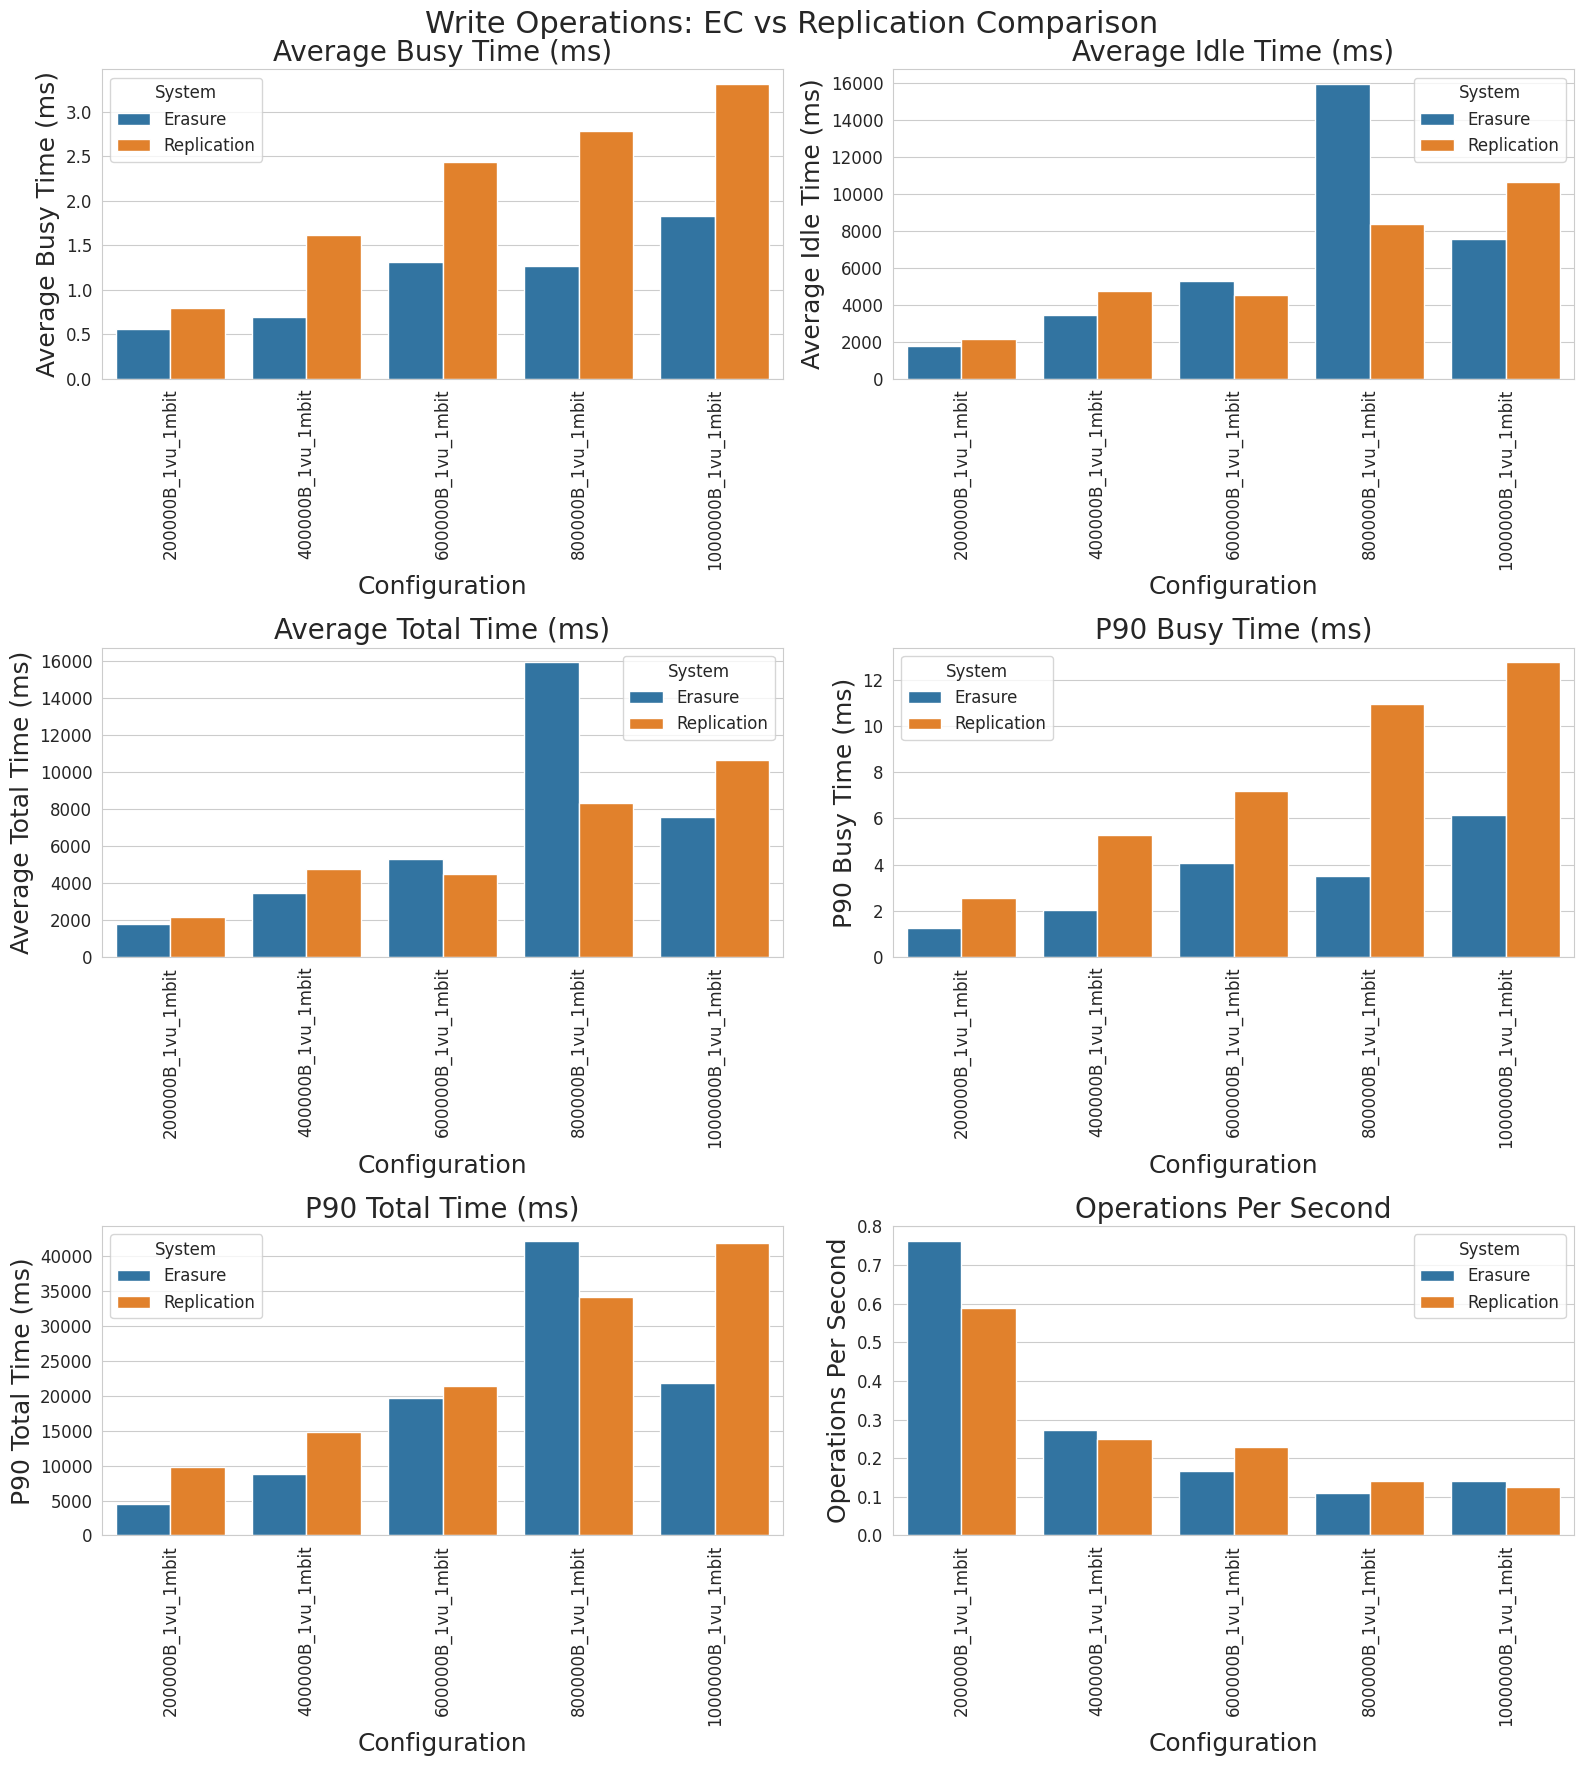

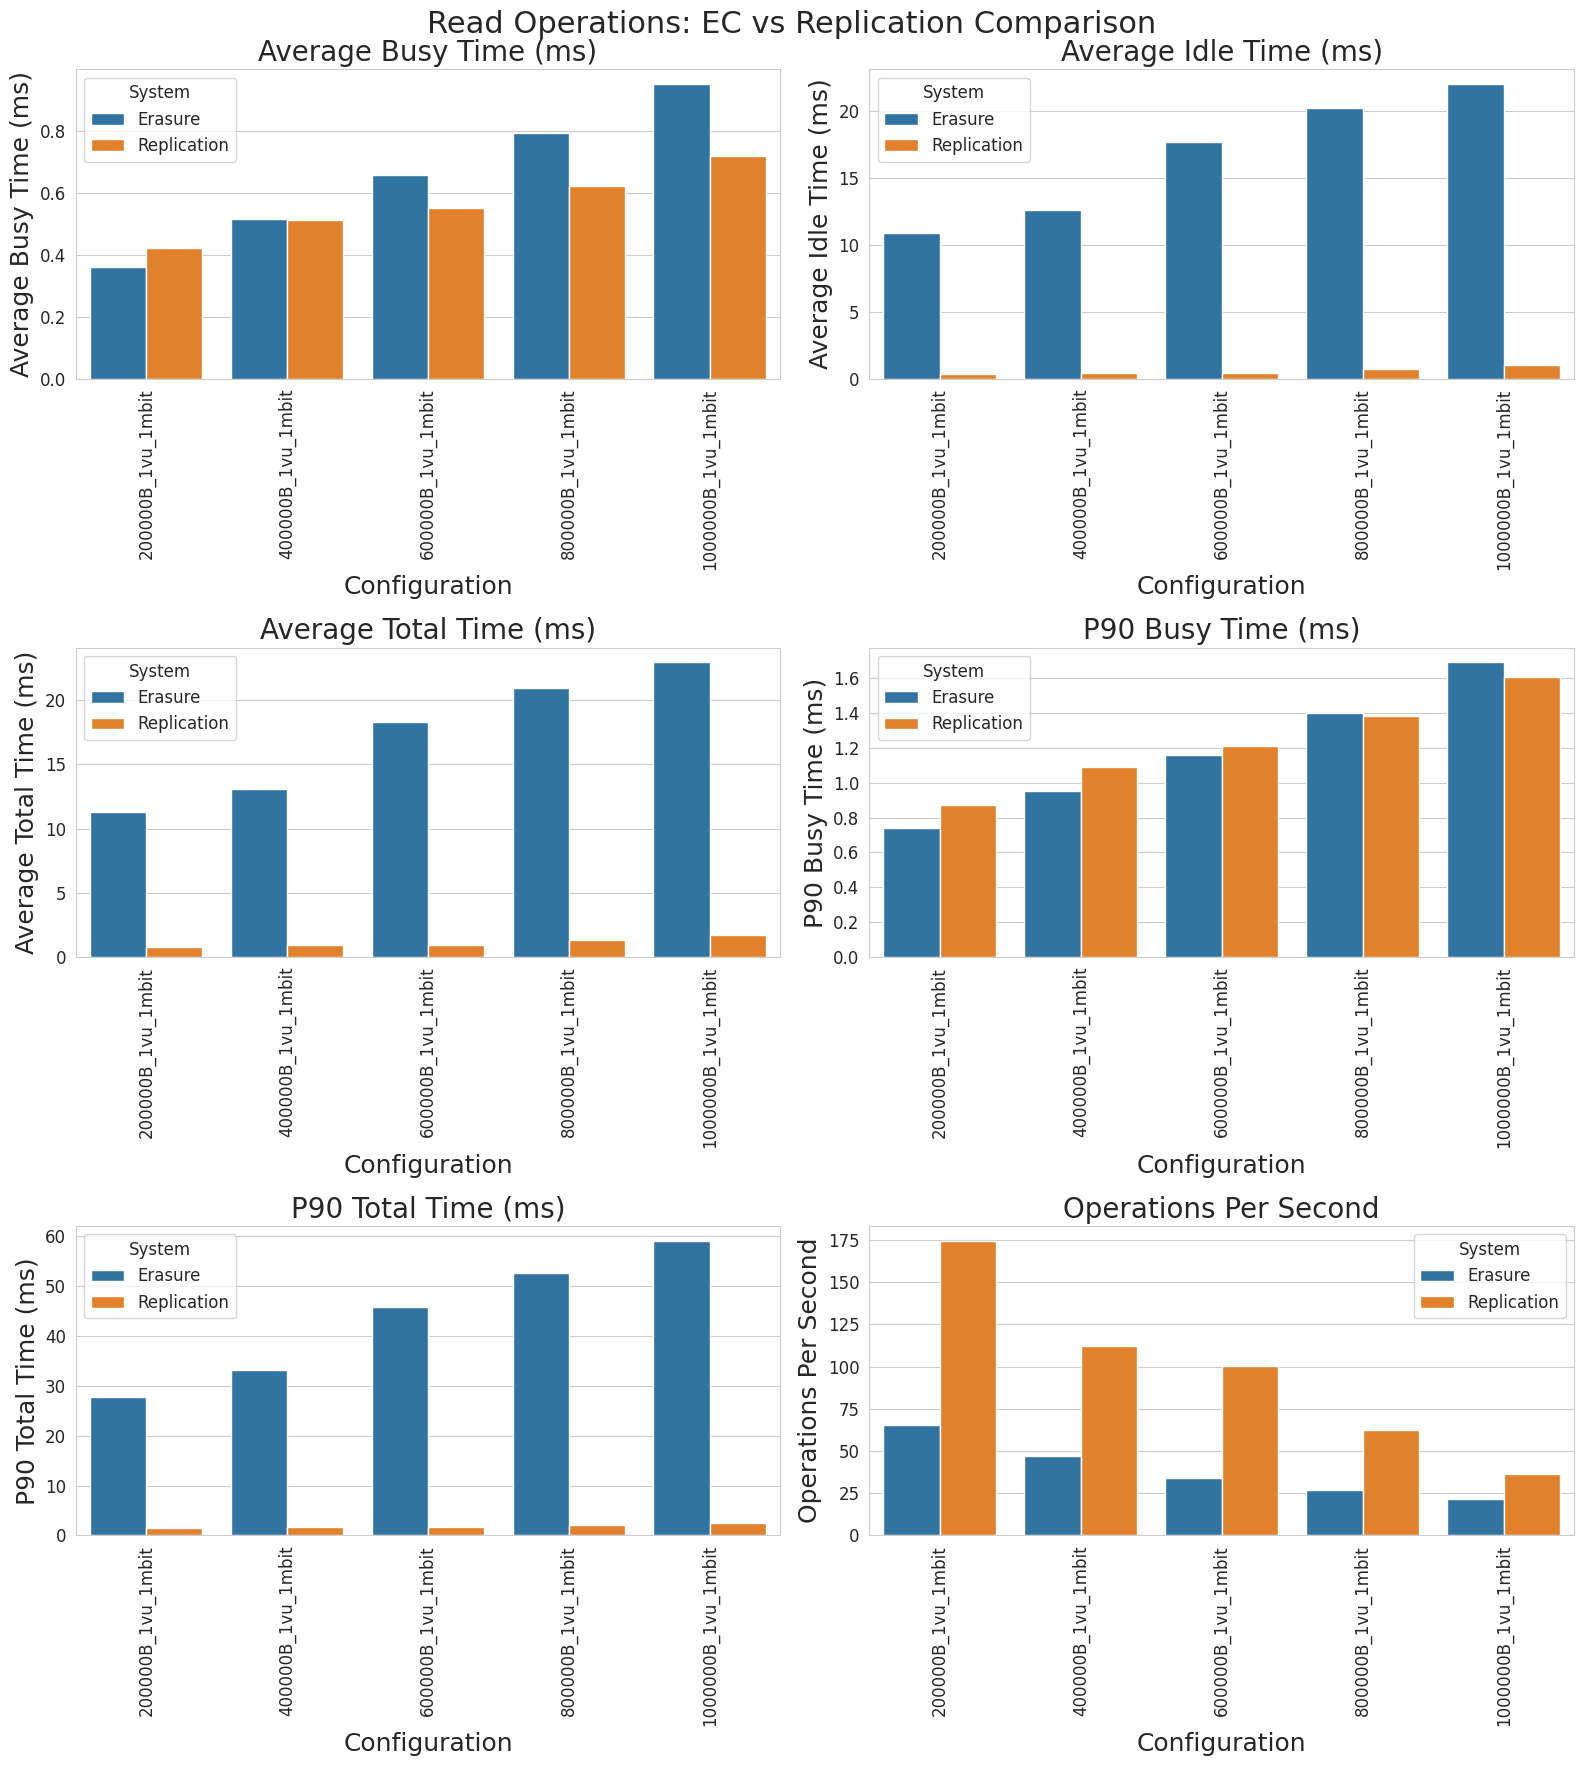

In [91]:
# Comparative Analysis: EC vs Replication
if not summary_df.empty:
    # Group by test type for separate analysis
    write_data = summary_df[summary_df['test_type'] == 'write']
    read_data = summary_df[summary_df['test_type'] == 'read']
    
    # Filter out HTTP_PUT, SET_MEMORY_STORE, and SET_PERSISTENT_STORE operations from read data analysis
    # by filtering the underlying timing data used to create the summary statistics
    filtered_processed_data = []
    for pd_item in processed_data:
        timings = pd_item['timings'].copy()
        
        # For read operations, filter out unwanted operation types
        if not timings.empty and timings['test_type'].iloc[0] == 'read':
            # Filter out HTTP_PUT operations and SET operations in memory/persistent stores
            filtered_timings = timings[
                ~(
                    (timings['operation_layer'] == 'HTTP_PUT') |
                    ((timings['operation_layer'] == 'MEMORY_STORE') & (timings['operation_type'] == 'SET')) |
                    ((timings['operation_layer'] == 'PERSISTENT_STORE') & (timings['operation_type'] == 'SET'))
                )
            ]
            
            # Recalculate metrics with filtered data
            if not filtered_timings.empty:
                # Get original metadata
                original_metrics = pd_item['metrics']
                
                # Recalculate metrics with filtered timing data
                updated_metrics = {
                    'test_type': original_metrics['test_type'],
                    'system_type': original_metrics['system_type'],
                    'payload_size': original_metrics['payload_size'],
                    'virtual_users': original_metrics['virtual_users'],
                    'bandwidth': original_metrics['bandwidth'],
                    'total_operations': len(filtered_timings),
                    'avg_busy_time_ms': filtered_timings['busy_time_ms'].mean(),
                    'avg_idle_time_ms': filtered_timings['idle_time_ms'].mean(),
                    'avg_total_time_ms': filtered_timings['total_time_ms'].mean(),
                    'p50_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.5),
                    'p90_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.9),
                    'p95_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.95),
                    'p50_total_time_ms': filtered_timings['total_time_ms'].quantile(0.5),
                    'p90_total_time_ms': filtered_timings['total_time_ms'].quantile(0.9),
                    'p95_total_time_ms': filtered_timings['total_time_ms'].quantile(0.95),
                    'operations_per_second': len(filtered_timings) / ((filtered_timings['timestamp'].max() - filtered_timings['timestamp'].min()).total_seconds()) if len(filtered_timings) > 1 else 0
                }
                
                # Recalculate layer-specific metrics with filtered data
                layer_metrics = {}
                for layer in filtered_timings['operation_layer'].unique():
                    layer_data = filtered_timings[filtered_timings['operation_layer'] == layer]
                    if not layer_data.empty:
                        layer_metrics[f'{layer.lower()}_count'] = len(layer_data)
                        layer_metrics[f'{layer.lower()}_avg_busy_ms'] = layer_data['busy_time_ms'].mean()
                        layer_metrics[f'{layer.lower()}_avg_idle_ms'] = layer_data['idle_time_ms'].mean()
                        layer_metrics[f'{layer.lower()}_p90_busy_ms'] = layer_data['busy_time_ms'].quantile(0.9)
                
                # Combine all metrics
                combined_metrics = {**updated_metrics, **layer_metrics}
                
                filtered_processed_data.append({
                    'metrics': combined_metrics,
                    'timings': filtered_timings,
                    'operations': pd_item['operations']
                })
        else:
            # Keep write data unchanged
            filtered_processed_data.append(pd_item)
    
    # Recreate summary dataframe with filtered data
    if filtered_processed_data:
        filtered_summary_df = pd.DataFrame([pd['metrics'] for pd in filtered_processed_data])
        # Use mapping dicts for custom sort order
        test_type_order = {'read': 0, 'write': 1}
        system_type_order = {'Erasure': 0, 'Replication': 1}
        filtered_summary_df['test_type_order'] = filtered_summary_df['test_type'].map(test_type_order)
        filtered_summary_df['system_type_order'] = filtered_summary_df['system_type'].map(system_type_order)
        filtered_summary_df = filtered_summary_df.sort_values(
            by=['test_type_order', 'system_type_order', 'payload_size', 'bandwidth', 'virtual_users']
        ).reset_index(drop=True)
        filtered_summary_df = filtered_summary_df.drop(columns=['test_type_order', 'system_type_order'])
        
        # Update the read_data with filtered results
        write_data = filtered_summary_df[filtered_summary_df['test_type'] == 'write']
        read_data = filtered_summary_df[filtered_summary_df['test_type'] == 'read']
        
        print(f"Applied filtering to read operations - excluded HTTP_PUT, SET_MEMORY_STORE, and SET_PERSISTENT_STORE operations")
        print(f"Updated summary contains {len(filtered_summary_df)} datasets")
    
    # Define metrics to compare
    timing_metrics = [
        ('avg_busy_time_ms', 'Average Busy Time (ms)'),
        ('avg_idle_time_ms', 'Average Idle Time (ms)'),
        ('avg_total_time_ms', 'Average Total Time (ms)'),
        ('p90_busy_time_ms', 'P90 Busy Time (ms)'),
        ('p90_total_time_ms', 'P90 Total Time (ms)'),
        ('operations_per_second', 'Operations Per Second')
    ]
    
    def plot_comparison(data, test_type):
        if data.empty:
            print(f"No data available for {test_type} operations")
            return
            
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle(f'{test_type.title()} Operations: EC vs Replication Comparison', fontsize=22)
        
        for idx, (metric, title) in enumerate(timing_metrics):
            ax = axes[idx // 2, idx % 2]
            
            # Create comparison data
            comparison_data = []
            for _, row in data.iterrows():
                comparison_data.append({
                    'System': row['system_type'],
                    'Value': row[metric],
                    'Config': f"{row['payload_size']}B_{row['virtual_users']}vu_{row['bandwidth']}"
                })
            
            comp_df = pd.DataFrame(comparison_data)
            
            if not comp_df.empty:
                sns.barplot(data=comp_df, x='Config', y='Value', hue='System', ax=ax)
                ax.set_title(title, fontsize=20)
                ax.set_xlabel('Configuration', fontsize=18)
                ax.set_ylabel(title, fontsize=18)
                ax.tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        plt.show()
    
    # Plot comparisons for write and read operations
    plot_comparison(write_data, 'write')
    plot_comparison(read_data, 'read')
else:
    print("No summary data available for comparison")

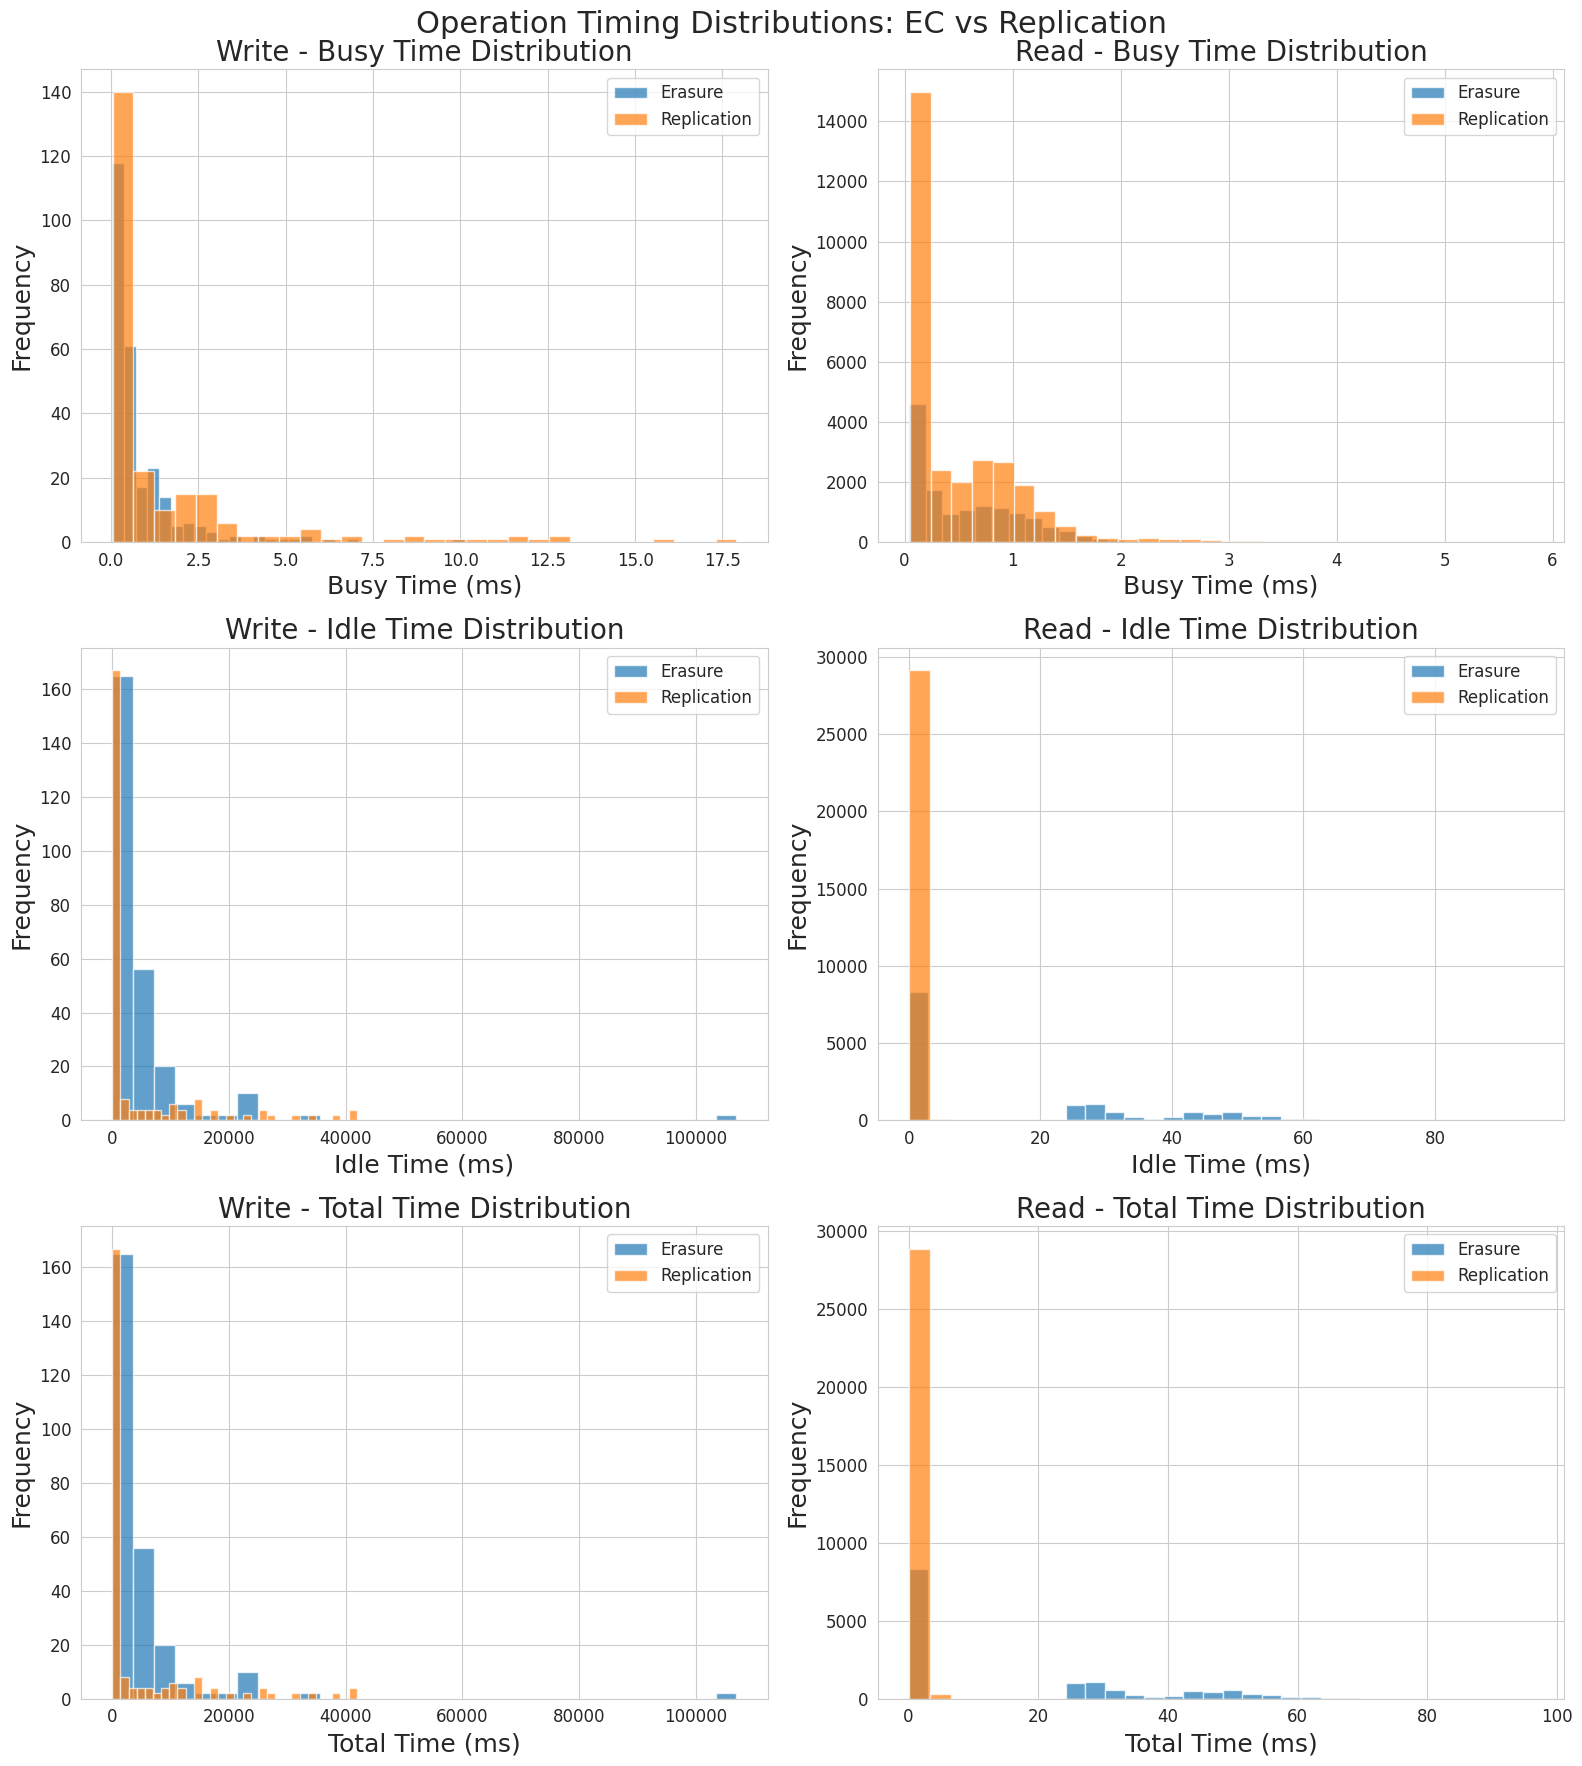

In [92]:
# Operation Timing Distributions
def plot_timing_distributions():
    """Plot timing distributions for different operation types"""
    # Access filtered data from global scope
    global filtered_processed_data, processed_data
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    # Combine all timing data
    all_timings = []
    for pd_item in data_to_use:
        timings = pd_item['timings'].copy()
        all_timings.append(timings)
    
    if not all_timings:
        print("No timing data available")
        return
    
    combined_timings = pd.concat(all_timings, ignore_index=True)
    
    # Plot distributions by system type and test type
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Operation Timing Distributions: EC vs Replication', fontsize=22)
    
    # Busy time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[0, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['busy_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Busy Time Distribution', fontsize=20)
            ax.set_xlabel('Busy Time (ms)', fontsize=18)
            ax.set_ylabel('Frequency', fontsize=18)
            ax.legend()
    
    # Idle time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[1, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['idle_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Idle Time Distribution', fontsize=20)
            ax.set_xlabel('Idle Time (ms)', fontsize=18)
            ax.set_ylabel('Frequency', fontsize=18)
            ax.legend()
    
    # Total time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[2, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['total_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Total Time Distribution', fontsize=20)
            ax.set_xlabel('Total Time (ms)', fontsize=18)
            ax.set_ylabel('Frequency', fontsize=18)
            ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_timing_distributions()

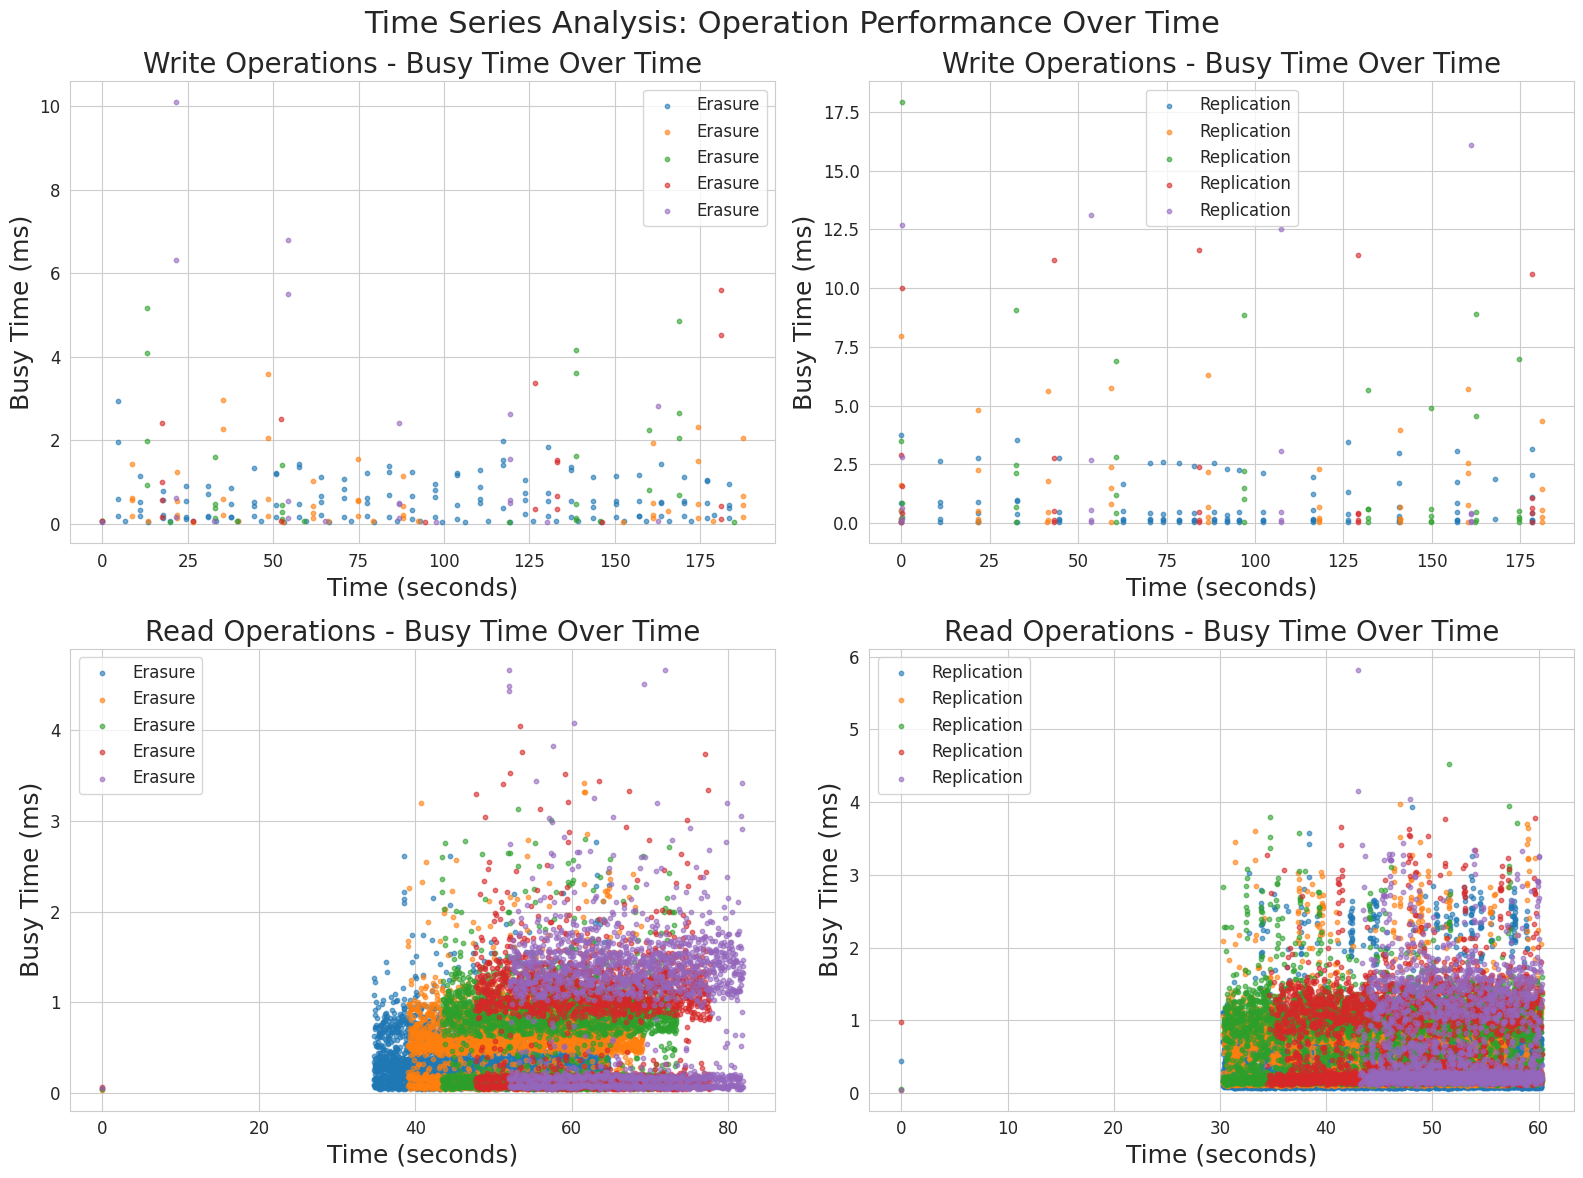

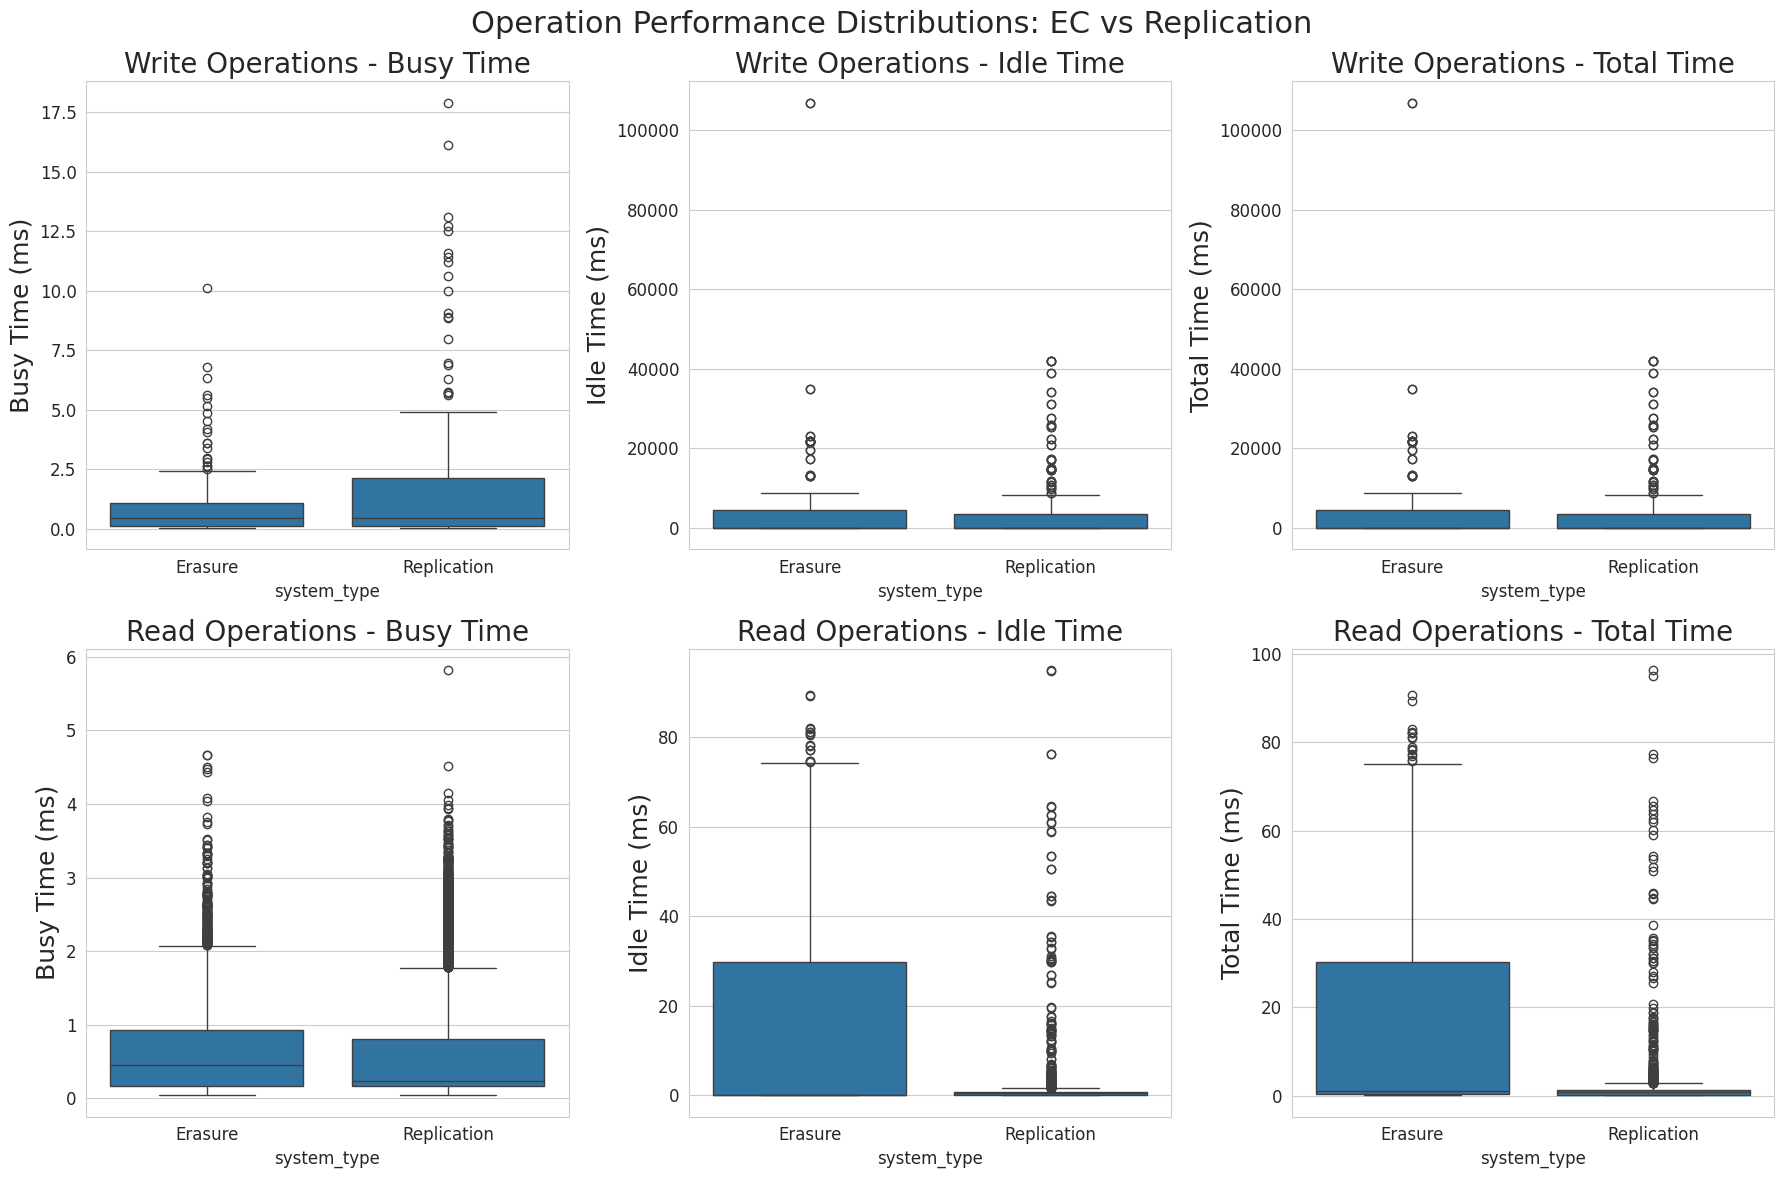

In [93]:
# Time Series Analysis and Boxplot Comparisons
def plot_time_series_and_boxplots():
    """Plot time series of operations and boxplot comparisons"""
    # Access filtered data from global scope
    global filtered_processed_data, processed_data
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    # Time series plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Series Analysis: Operation Performance Over Time', fontsize=22)
    
    for pd_item in data_to_use:
        timings = pd_item['timings']
        if timings.empty:
            continue
            
        test_type = timings['test_type'].iloc[0]
        system_type = timings['system_type'].iloc[0]
        
        # Calculate relative time in seconds from start
        start_time = timings['timestamp'].min()
        timings['relative_time'] = (timings['timestamp'] - start_time).dt.total_seconds()
        
        # Plot busy time over time
        if test_type == 'write':
            ax = axes[0, 0] if system_type == 'Erasure' else axes[0, 1]
            ax.scatter(timings['relative_time'], timings['busy_time_ms'], 
                      alpha=0.6, s=10, label=f'{system_type}')
            ax.set_title(f'Write Operations - Busy Time Over Time', fontsize=20)
            ax.set_xlabel('Time (seconds)', fontsize=18)
            ax.set_ylabel('Busy Time (ms)', fontsize=18)
            ax.legend()
        
        elif test_type == 'read':
            ax = axes[1, 0] if system_type == 'Erasure' else axes[1, 1]
            ax.scatter(timings['relative_time'], timings['busy_time_ms'], 
                      alpha=0.6, s=10, label=f'{system_type}')
            ax.set_title(f'Read Operations - Busy Time Over Time', fontsize=20)
            ax.set_xlabel('Time (seconds)', fontsize=18)
            ax.set_ylabel('Busy Time (ms)', fontsize=18)
            ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Boxplot comparisons
    if data_to_use:
        all_timings = pd.concat([pd_item['timings'] for pd_item in data_to_use], ignore_index=True)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Operation Performance Distributions: EC vs Replication', fontsize=22)
        
        # Write operations - Busy time
        write_data = all_timings[all_timings['test_type'] == 'write']
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='busy_time_ms', ax=axes[0, 0])
            axes[0, 0].set_title('Write Operations - Busy Time', fontsize=20)
            axes[0, 0].set_ylabel('Busy Time (ms)', fontsize=18)
        
        # Write operations - Idle time
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='idle_time_ms', ax=axes[0, 1])
            axes[0, 1].set_title('Write Operations - Idle Time', fontsize=20)
            axes[0, 1].set_ylabel('Idle Time (ms)', fontsize=18)
        
        # Write operations - Total time
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='total_time_ms', ax=axes[0, 2])
            axes[0, 2].set_title('Write Operations - Total Time', fontsize=20)
            axes[0, 2].set_ylabel('Total Time (ms)', fontsize=18)
        
        # Read operations - Busy time
        read_data = all_timings[all_timings['test_type'] == 'read']
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='busy_time_ms', ax=axes[1, 0])
            axes[1, 0].set_title('Read Operations - Busy Time', fontsize=20)
            axes[1, 0].set_ylabel('Busy Time (ms)', fontsize=18)
        
        # Read operations - Idle time
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='idle_time_ms', ax=axes[1, 1])
            axes[1, 1].set_title('Read Operations - Idle Time', fontsize=20)
            axes[1, 1].set_ylabel('Idle Time (ms)', fontsize=18)
        
        # Read operations - Total time
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='total_time_ms', ax=axes[1, 2])
            axes[1, 2].set_title('Read Operations - Total Time', fontsize=20)
            axes[1, 2].set_ylabel('Total Time (ms)', fontsize=18)
        
        plt.tight_layout()
        plt.show()

plot_time_series_and_boxplots()

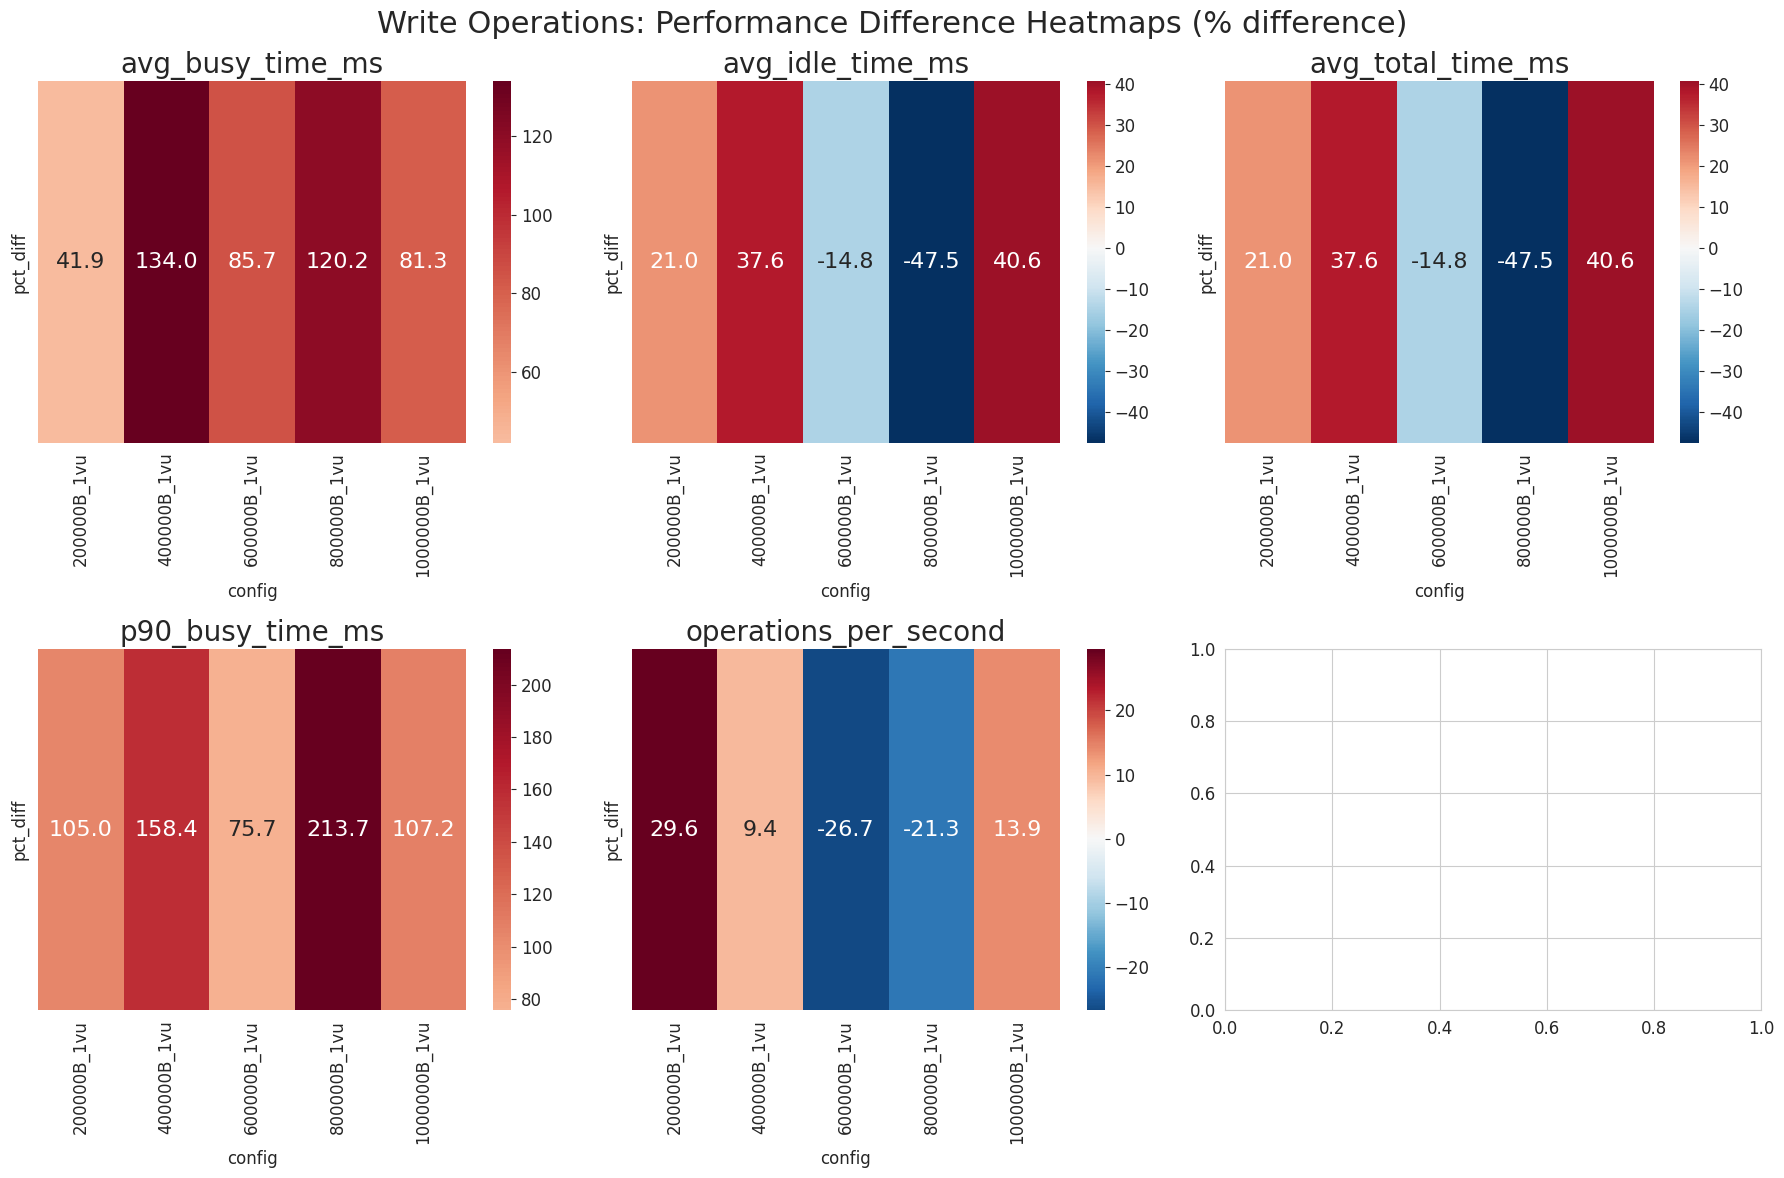

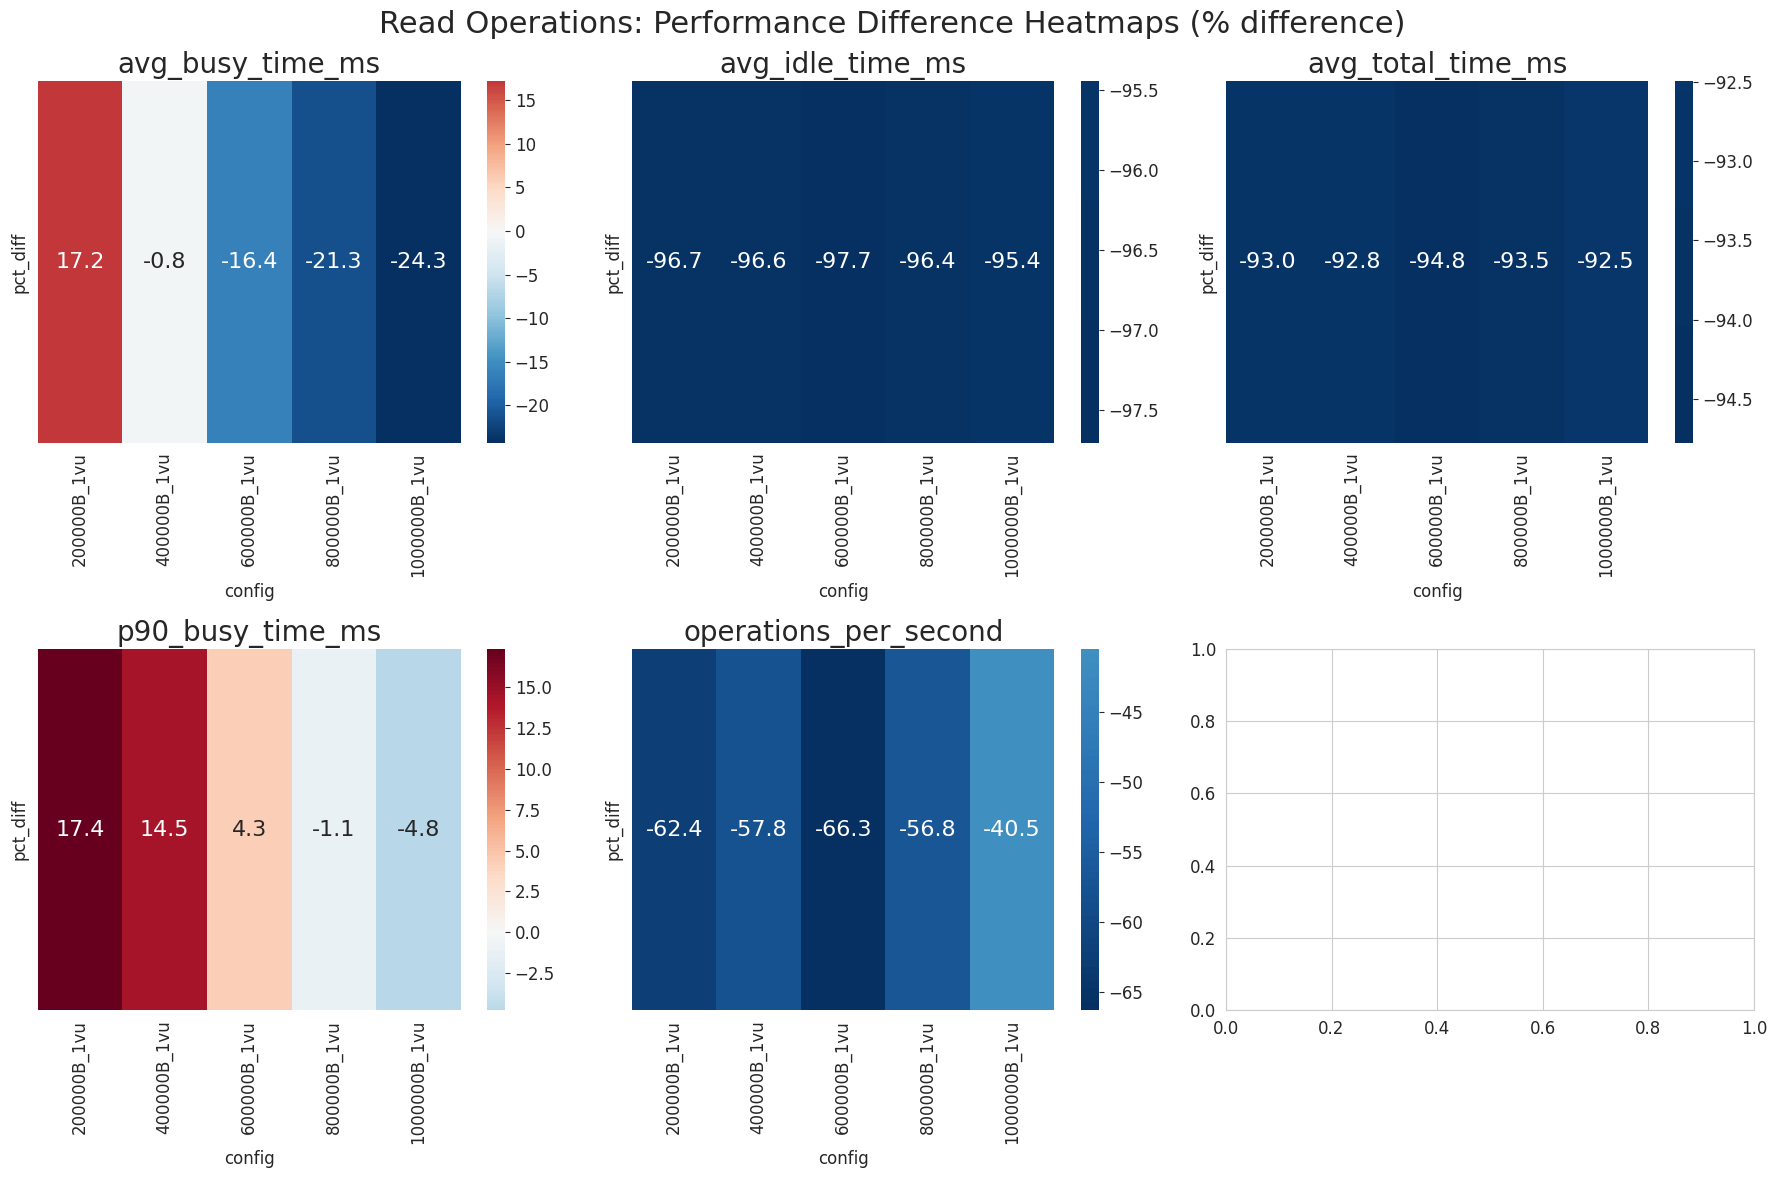

Summary Statistics: EC vs Replication Performance

WRITE OPERATIONS:
----------------------------------------

Configuration: 200000B_1vu_1mbit
System: Erasure
  Total Operations: 140
  Avg Busy Time: 0.56 ms
  P90 Busy Time: 1.24 ms
  Avg Total Time: 1790.42 ms
  Operations/sec: 0.76

Configuration: 400000B_1vu_1mbit
System: Erasure
  Total Operations: 51
  Avg Busy Time: 0.69 ms
  P90 Busy Time: 2.05 ms
  Avg Total Time: 3461.09 ms
  Operations/sec: 0.27

Configuration: 600000B_1vu_1mbit
System: Erasure
  Total Operations: 31
  Avg Busy Time: 1.31 ms
  P90 Busy Time: 4.08 ms
  Avg Total Time: 5298.10 ms
  Operations/sec: 0.17

Configuration: 800000B_1vu_1mbit
System: Erasure
  Total Operations: 20
  Avg Busy Time: 1.26 ms
  P90 Busy Time: 3.49 ms
  Avg Total Time: 15941.27 ms
  Operations/sec: 0.11

Configuration: 1000000B_1vu_1mbit
System: Erasure
  Total Operations: 23
  Avg Busy Time: 1.82 ms
  P90 Busy Time: 6.15 ms
  Avg Total Time: 7567.05 ms
  Operations/sec: 0.14

Configurati

In [94]:
# Performance Heatmaps and Summary Statistics
def plot_performance_heatmaps():
    """Create heatmaps showing performance differences between EC and Replication"""
    # Access filtered data from global scope
    global filtered_summary_df, summary_df
    
    # Use filtered_summary_df if it exists, otherwise use original summary_df
    df_to_use = filtered_summary_df if 'filtered_summary_df' in globals() and not filtered_summary_df.empty else summary_df
    
    if df_to_use.empty:
        print("No summary data available")
        return
    
    # Calculate performance differences
    metrics_to_compare = ['avg_busy_time_ms', 'avg_idle_time_ms', 'avg_total_time_ms', 'p90_busy_time_ms', 'operations_per_second']
    
    for test_type in ['write', 'read']:
        test_data = df_to_use[df_to_use['test_type'] == test_type]
        
        if test_data.empty:
            continue
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{test_type.title()} Operations: Performance Difference Heatmaps (% difference)', fontsize=22)
        
        for idx, metric in enumerate(metrics_to_compare):
            ax = axes[idx // 3, idx % 3]
            
            # Prepare data for heatmap
            ec_data = test_data[test_data['system_type'] == 'Erasure']
            repl_data = test_data[test_data['system_type'] == 'Replication']
            
            if ec_data.empty or repl_data.empty:
                ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric} - No Data', fontsize=20)
                continue
            
            # Calculate percentage difference (Replication - EC) / EC * 100
            # Positive values mean Replication is worse (higher latency) or better (higher throughput)
            diff_data = []
            
            for _, ec_row in ec_data.iterrows():
                matching_repl = repl_data[
                    (repl_data['payload_size'] == ec_row['payload_size']) &
                    (repl_data['virtual_users'] == ec_row['virtual_users']) &
                    (repl_data['bandwidth'] == ec_row['bandwidth'])
                ]
                
                if not matching_repl.empty:
                    repl_val = matching_repl.iloc[0][metric]
                    ec_val = ec_row[metric]
                    
                    if ec_val != 0:
                        if metric == 'operations_per_second':
                            # For throughput, positive means EC is better
                            pct_diff = (ec_val - repl_val) / repl_val * 100
                        else:
                            # For latency/timing metrics, positive means Replication is worse
                            pct_diff = (repl_val - ec_val) / ec_val * 100
                        
                        diff_data.append({
                            'payload_size': ec_row['payload_size'],
                            'virtual_users': ec_row['virtual_users'],
                            'bandwidth': ec_row['bandwidth'],
                            'pct_diff': pct_diff
                        })
            
            if diff_data:
                diff_df = pd.DataFrame(diff_data)
                diff_df['config'] = diff_df.apply(lambda x: f"{x['payload_size']}B_{x['virtual_users']}vu", axis=1)
                
                # Create pivot table for heatmap
                if len(diff_df['bandwidth'].unique()) > 1:
                    pivot = diff_df.pivot(index='bandwidth', columns='config', values='pct_diff')
                else:
                    # If only one bandwidth, create a simple bar chart
                    pivot = diff_df.set_index('config')[['pct_diff']].T
                
                sns.heatmap(pivot, annot=True, cmap='RdBu_r', center=0, fmt='.1f', ax=ax, annot_kws={'fontsize': 16})
                
                ax.set_title(f'{metric}', fontsize=20)
            else:
                ax.text(0.5, 0.5, 'No matching data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric} - No Matching Data', fontsize=20)
        
        plt.tight_layout()
        plt.show()

plot_performance_heatmaps()

# Summary Statistics Table
def display_summary_statistics():
    """Display summary statistics for all configurations"""
    # Access filtered data from global scope
    global filtered_summary_df, summary_df
    
    # Use filtered_summary_df if it exists, otherwise use original summary_df
    df_to_use = filtered_summary_df if 'filtered_summary_df' in globals() and not filtered_summary_df.empty else summary_df
    
    if df_to_use.empty:
        print("No summary data available")
        return
    
    print("Summary Statistics: EC vs Replication Performance")
    print("=" * 80)
    
    for test_type in ['write', 'read']:
        test_data = df_to_use[df_to_use['test_type'] == test_type]
        
        if test_data.empty:
            continue
        
        print(f"\n{test_type.upper()} OPERATIONS:")
        print("-" * 40)
        
        # Group by configuration
        for _, row in test_data.iterrows():
            config = f"{row['payload_size']}B_{row['virtual_users']}vu_{row['bandwidth']}"
            print(f"\nConfiguration: {config}")
            print(f"System: {row['system_type']}")
            print(f"  Total Operations: {row['total_operations']}")
            print(f"  Avg Busy Time: {row['avg_busy_time_ms']:.2f} ms")
            print(f"  P90 Busy Time: {row['p90_busy_time_ms']:.2f} ms")
            print(f"  Avg Total Time: {row['avg_total_time_ms']:.2f} ms")
            print(f"  Operations/sec: {row['operations_per_second']:.2f}")

display_summary_statistics()

DETAILED OPERATION TYPE ANALYSIS

WRITE OPERATIONS:
--------------------------------------------------

Erasure System:
Operation                 Count    Avg Busy     Med Busy     Avg Total    Med Total   
----------------------------------------------------------------------------------------------------
SET_PERSISTENT_STORE      55       1.94         1.42         1.95         1.43        
SET_MEMORY_STORE          50       1.33         0.58         1.35         0.60        
HTTP_PUT_HTTP_PUT         100      0.43         0.43         10841.03     4510.34     
GET_PERSISTENT_STORE      55       0.06         0.05         0.07         0.07        

Top 3 Slowest Operations by Average Busy Time:
  1. SET_PERSISTENT_STORE: 1.94ms avg busy time
  2. SET_MEMORY_STORE: 1.33ms avg busy time
  3. HTTP_PUT_HTTP_PUT: 0.43ms avg busy time

Replication System:
Operation                 Count    Avg Busy     Med Busy     Avg Total    Med Total   
---------------------------------------------------

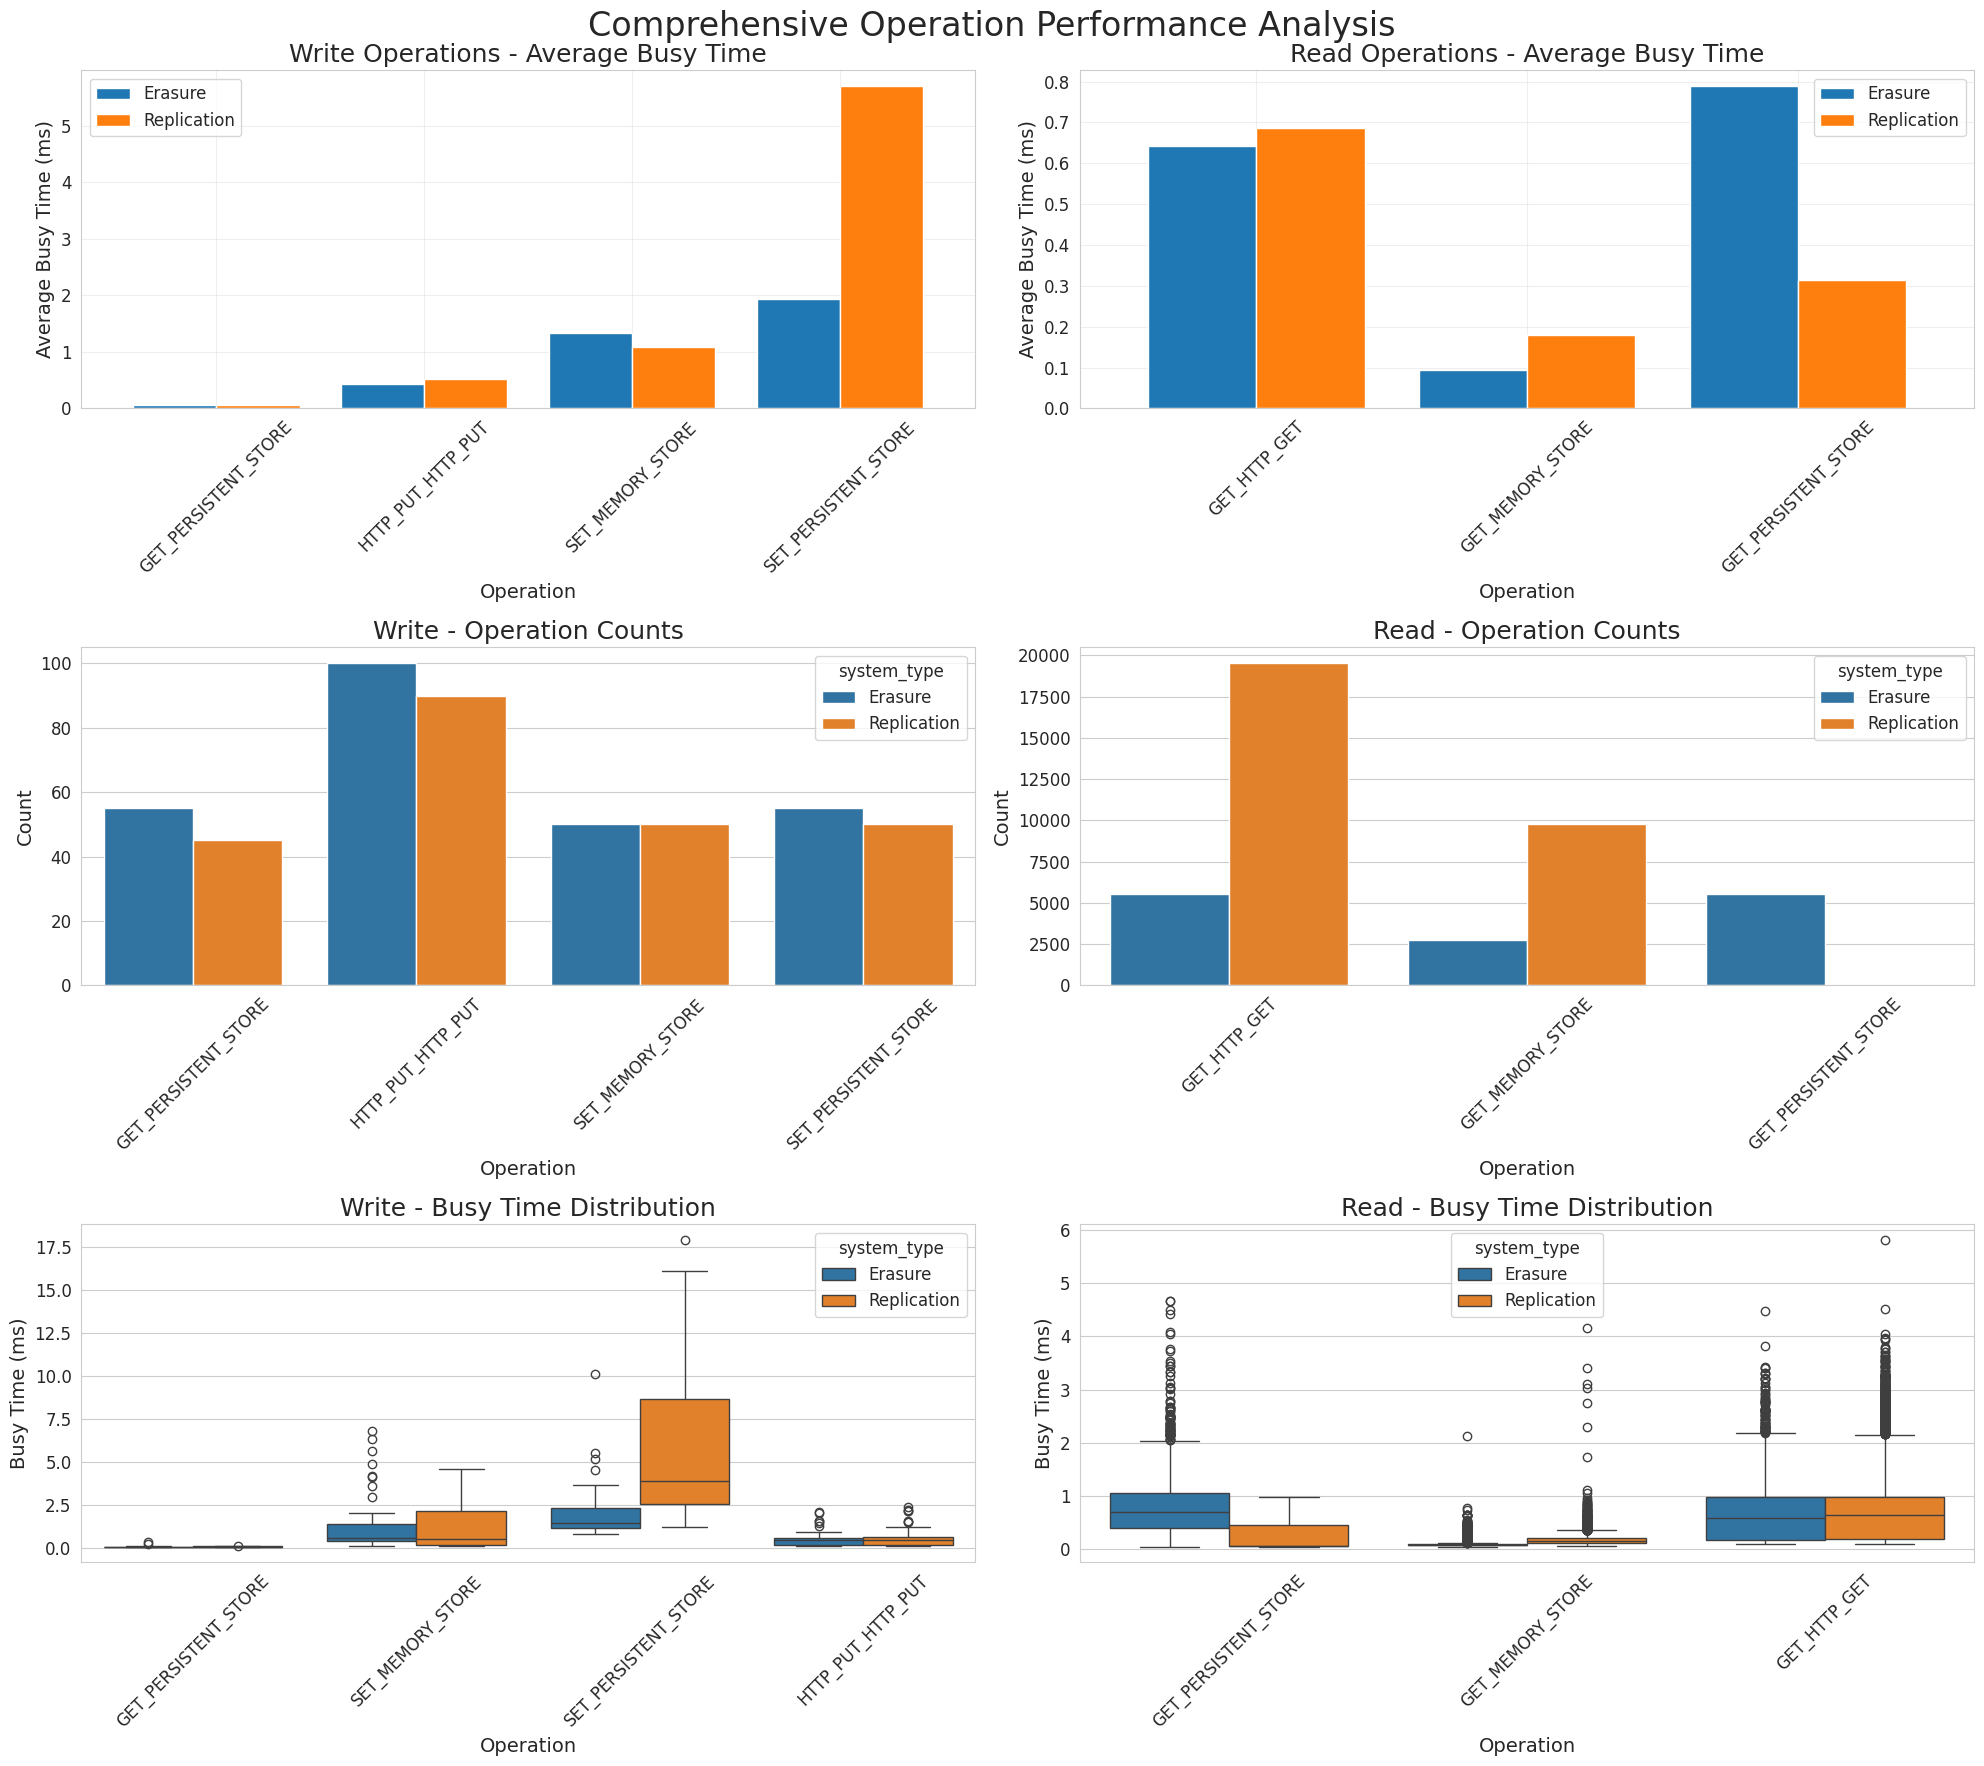



OPERATION PERFORMANCE RANKING

WRITE OPERATIONS - Ranked by Average Busy Time:
Rank  Operation                      Avg Busy (ms)   Median Busy (ms)   Count   
-------------------------------------------------------------------------------------
1     SET_PERSISTENT_STORE           3.73            2.32               105     
2     SET_MEMORY_STORE               1.21            0.58               100     
3     HTTP_PUT_HTTP_PUT              0.47            0.43               190     
4     GET_PERSISTENT_STORE           0.06            0.05               100     

READ OPERATIONS - Ranked by Average Busy Time:
Rank  Operation                      Avg Busy (ms)   Median Busy (ms)   Count   
-------------------------------------------------------------------------------------
1     GET_PERSISTENT_STORE           0.79            0.70               5550    
2     GET_HTTP_GET                   0.68            0.62               25052   
3     GET_MEMORY_STORE               0.16          

In [105]:
# Enhanced Operation Type Analysis
def analyze_operation_types():
    """Analyze different operation types within the traces with detailed timing breakdown"""
    # Access filtered data from global scope
    global filtered_processed_data, processed_data
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    # Combine all timing data and analyze by operation type
    all_timings = pd.concat([pd_item['timings'] for pd_item in data_to_use], ignore_index=True)
    
    if all_timings.empty:
        print("No timing data available")
        return
    
    print("DETAILED OPERATION TYPE ANALYSIS")
    print("=" * 80)
    
    # Analyze by test type (write vs read)
    for test_type in ['write', 'read']:
        test_timings = all_timings[all_timings['test_type'] == test_type]
        
        if test_timings.empty:
            continue
            
        print(f"\n{test_type.upper()} OPERATIONS:")
        print("-" * 50)
        
        # Group by system type and operation
        for system_type in ['Erasure', 'Replication']:
            system_timings = test_timings[test_timings['system_type'] == system_type]
            
            if system_timings.empty:
                continue
                
            print(f"\n{system_type} System:")
            
            # Calculate operation statistics
            op_stats = system_timings.groupby('operation').agg({
                'busy_time_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
                'idle_time_ms': ['mean', 'median'],
                'total_time_ms': ['mean', 'median', 'min', 'max']
            }).round(2)
            
            # Flatten column names
            op_stats.columns = ['_'.join(col).strip() for col in op_stats.columns.values]
            
            # Sort by average busy time (descending) to show longest operations first
            op_stats_sorted = op_stats.sort_values('busy_time_ms_mean', ascending=False)
            
            print(f"{'Operation':<25} {'Count':<8} {'Avg Busy':<12} {'Med Busy':<12} {'Avg Total':<12} {'Med Total':<12}")
            print("-" * 100)
            
            for operation, row in op_stats_sorted.iterrows():
                print(f"{operation:<25} {int(row['busy_time_ms_count']):<8} "
                      f"{row['busy_time_ms_mean']:<12.2f} {row['busy_time_ms_median']:<12.2f} "
                      f"{row['total_time_ms_mean']:<12.2f} {row['total_time_ms_median']:<12.2f}")
            
            # Show top 3 slowest operations
            print(f"\nTop 3 Slowest Operations by Average Busy Time:")
            top_3 = op_stats_sorted.head(3)
            for i, (operation, row) in enumerate(top_3.iterrows(), 1):
                print(f"  {i}. {operation}: {row['busy_time_ms_mean']:.2f}ms avg busy time")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Comprehensive Operation Performance Analysis', fontsize=24)
    
    # 1. Average Busy Time by Operation (Write)
    write_timings = all_timings[all_timings['test_type'] == 'write']
    if not write_timings.empty:
        write_avg = write_timings.groupby(['operation', 'system_type'])['busy_time_ms'].mean().reset_index()
        write_avg_pivot = write_avg.pivot(index='operation', columns='system_type', values='busy_time_ms').fillna(0)
        
        ax = axes[0, 0]
        write_avg_pivot.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title('Write Operations - Average Busy Time', fontsize=18)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=14)
        ax.set_xlabel('Operation', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Average Busy Time by Operation (Read)
    read_timings = all_timings[all_timings['test_type'] == 'read']
    if not read_timings.empty:
        read_avg = read_timings.groupby(['operation', 'system_type'])['busy_time_ms'].mean().reset_index()
        read_avg_pivot = read_avg.pivot(index='operation', columns='system_type', values='busy_time_ms').fillna(0)
        
        ax = axes[0, 1]
        read_avg_pivot.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title('Read Operations - Average Busy Time', fontsize=18)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=14)
        ax.set_xlabel('Operation', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 3. Operation Count Comparison
    op_counts = all_timings.groupby(['test_type', 'system_type', 'operation']).size().reset_index(name='count')
    
    for idx, test_type in enumerate(['write', 'read']):
        test_ops = op_counts[op_counts['test_type'] == test_type]
        
        if not test_ops.empty:
            ax = axes[1, idx]
            sns.barplot(data=test_ops, x='operation', y='count', hue='system_type', ax=ax)
            ax.set_title(f'{test_type.title()} - Operation Counts', fontsize=18)
            ax.set_xlabel('Operation', fontsize=14)
            ax.set_ylabel('Count', fontsize=14)
            ax.tick_params(axis='x', rotation=45)
    
    # 4. Box plots for timing distribution
    for idx, test_type in enumerate(['write', 'read']):
        test_timings = all_timings[all_timings['test_type'] == test_type]
        
        if not test_timings.empty:
            ax = axes[2, idx]
            sns.boxplot(data=test_timings, x='operation', y='busy_time_ms', hue='system_type', ax=ax)
            ax.set_title(f'{test_type.title()} - Busy Time Distribution', fontsize=18)
            ax.set_xlabel('Operation', fontsize=14)
            ax.set_ylabel('Busy Time (ms)', fontsize=14)
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table showing all operations ranked by average time
    print(f"\n\nOPERATION PERFORMANCE RANKING")
    print("=" * 80)
    
    # Calculate overall averages across all systems and configurations
    overall_stats = all_timings.groupby(['test_type', 'operation']).agg({
        'busy_time_ms': ['count', 'mean', 'median', 'std'],
        'total_time_ms': ['mean', 'median']
    }).round(2)
    
    overall_stats.columns = ['_'.join(col).strip() for col in overall_stats.columns.values]
    
    for test_type in ['write', 'read']:
        test_stats = overall_stats[overall_stats.index.get_level_values(0) == test_type]
        
        if test_stats.empty:
            continue
            
        # Remove test_type from index to show only operation names
        test_stats.index = test_stats.index.droplevel(0)
        test_stats_sorted = test_stats.sort_values('busy_time_ms_mean', ascending=False)
        
        print(f"\n{test_type.upper()} OPERATIONS - Ranked by Average Busy Time:")
        print(f"{'Rank':<5} {'Operation':<30} {'Avg Busy (ms)':<15} {'Median Busy (ms)':<18} {'Count':<8}")
        print("-" * 85)
        
        for rank, (operation, row) in enumerate(test_stats_sorted.iterrows(), 1):
            print(f"{rank:<5} {operation:<30} {row['busy_time_ms_mean']:<15.2f} "
                  f"{row['busy_time_ms_median']:<18.2f} {int(row['busy_time_ms_count']):<8}")

analyze_operation_types()

# Bandwidth Impact Analysis
def analyze_bandwidth_impact():
    """Analyze the impact of bandwidth limitations on performance"""
    # Access filtered data from global scope
    global filtered_summary_df, summary_df
    
    # Use filtered_summary_df if it exists, otherwise use original summary_df
    df_to_use = filtered_summary_df if 'filtered_summary_df' in globals() and not filtered_summary_df.empty else summary_df
    
    if df_to_use.empty:
        print("No summary data available for bandwidth analysis")
        return
    
    # Check if we have multiple bandwidth configurations
    unique_bandwidths = df_to_use['bandwidth'].unique()
    
    if len(unique_bandwidths) <= 1:
        print(f"Only one bandwidth configuration found: {unique_bandwidths}")
        return
    
    print("Bandwidth Impact Analysis:")
    print("=" * 50)
    
    metrics = ['avg_busy_time_ms', 'avg_idle_time_ms', 'avg_total_time_ms', 'operations_per_second']
    
    fig, axes = plt.subplots(len(metrics), 2, figsize=(16, 4 * len(metrics)))
    fig.suptitle('Bandwidth Impact on Performance: EC vs Replication', fontsize=22)
    
    for metric_idx, metric in enumerate(metrics):
        for test_idx, test_type in enumerate(['write', 'read']):
            ax = axes[metric_idx, test_idx] if len(metrics) > 1 else axes[test_idx]
            
            test_data = df_to_use[df_to_use['test_type'] == test_type]
            
            if not test_data.empty:
                # Create pivot table for line plot
                pivot_data = test_data.pivot_table(
                    index='bandwidth', 
                    columns='system_type', 
                    values=metric, 
                    aggfunc='mean'
                )
                
                for system in pivot_data.columns:
                    ax.plot(range(len(pivot_data.index)), pivot_data[system], 
                           marker='o', label=system, linewidth=2, markersize=8)
                
                ax.set_title(f'{test_type.title()} - {metric}', fontsize=20)
                ax.set_xlabel('Bandwidth Configuration', fontsize=18)
                ax.set_ylabel(metric, fontsize=18)
                ax.set_xticks(range(len(pivot_data.index)))
                ax.set_xticklabels(pivot_data.index, rotation=45)
                ax.legend()
                ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_bandwidth_impact()

OPERATION PERFORMANCE SUMMARY - BOTTLENECK IDENTIFICATION

TOP 10 SLOWEST OPERATIONS (by Average Busy Time):
--------------------------------------------------------------------------------
Rank Test   System       Operation                 Avg Time   Count   
--------------------------------------------------------------------------------
1    write  Replication  SET_PERSISTENT_STORE      5.697      50      
2    write  Erasure      SET_PERSISTENT_STORE      1.941      55      
3    write  Erasure      SET_MEMORY_STORE          1.327      50      
4    write  Replication  SET_MEMORY_STORE          1.094      50      
5    read   Erasure      GET_PERSISTENT_STORE      0.788      5545    
6    read   Replication  GET_HTTP_GET              0.686      19512   
7    read   Erasure      GET_HTTP_GET              0.642      5540    
8    write  Replication  HTTP_PUT_HTTP_PUT         0.516      90      
9    write  Erasure      HTTP_PUT_HTTP_PUT         0.433      100     
10   read   Replica

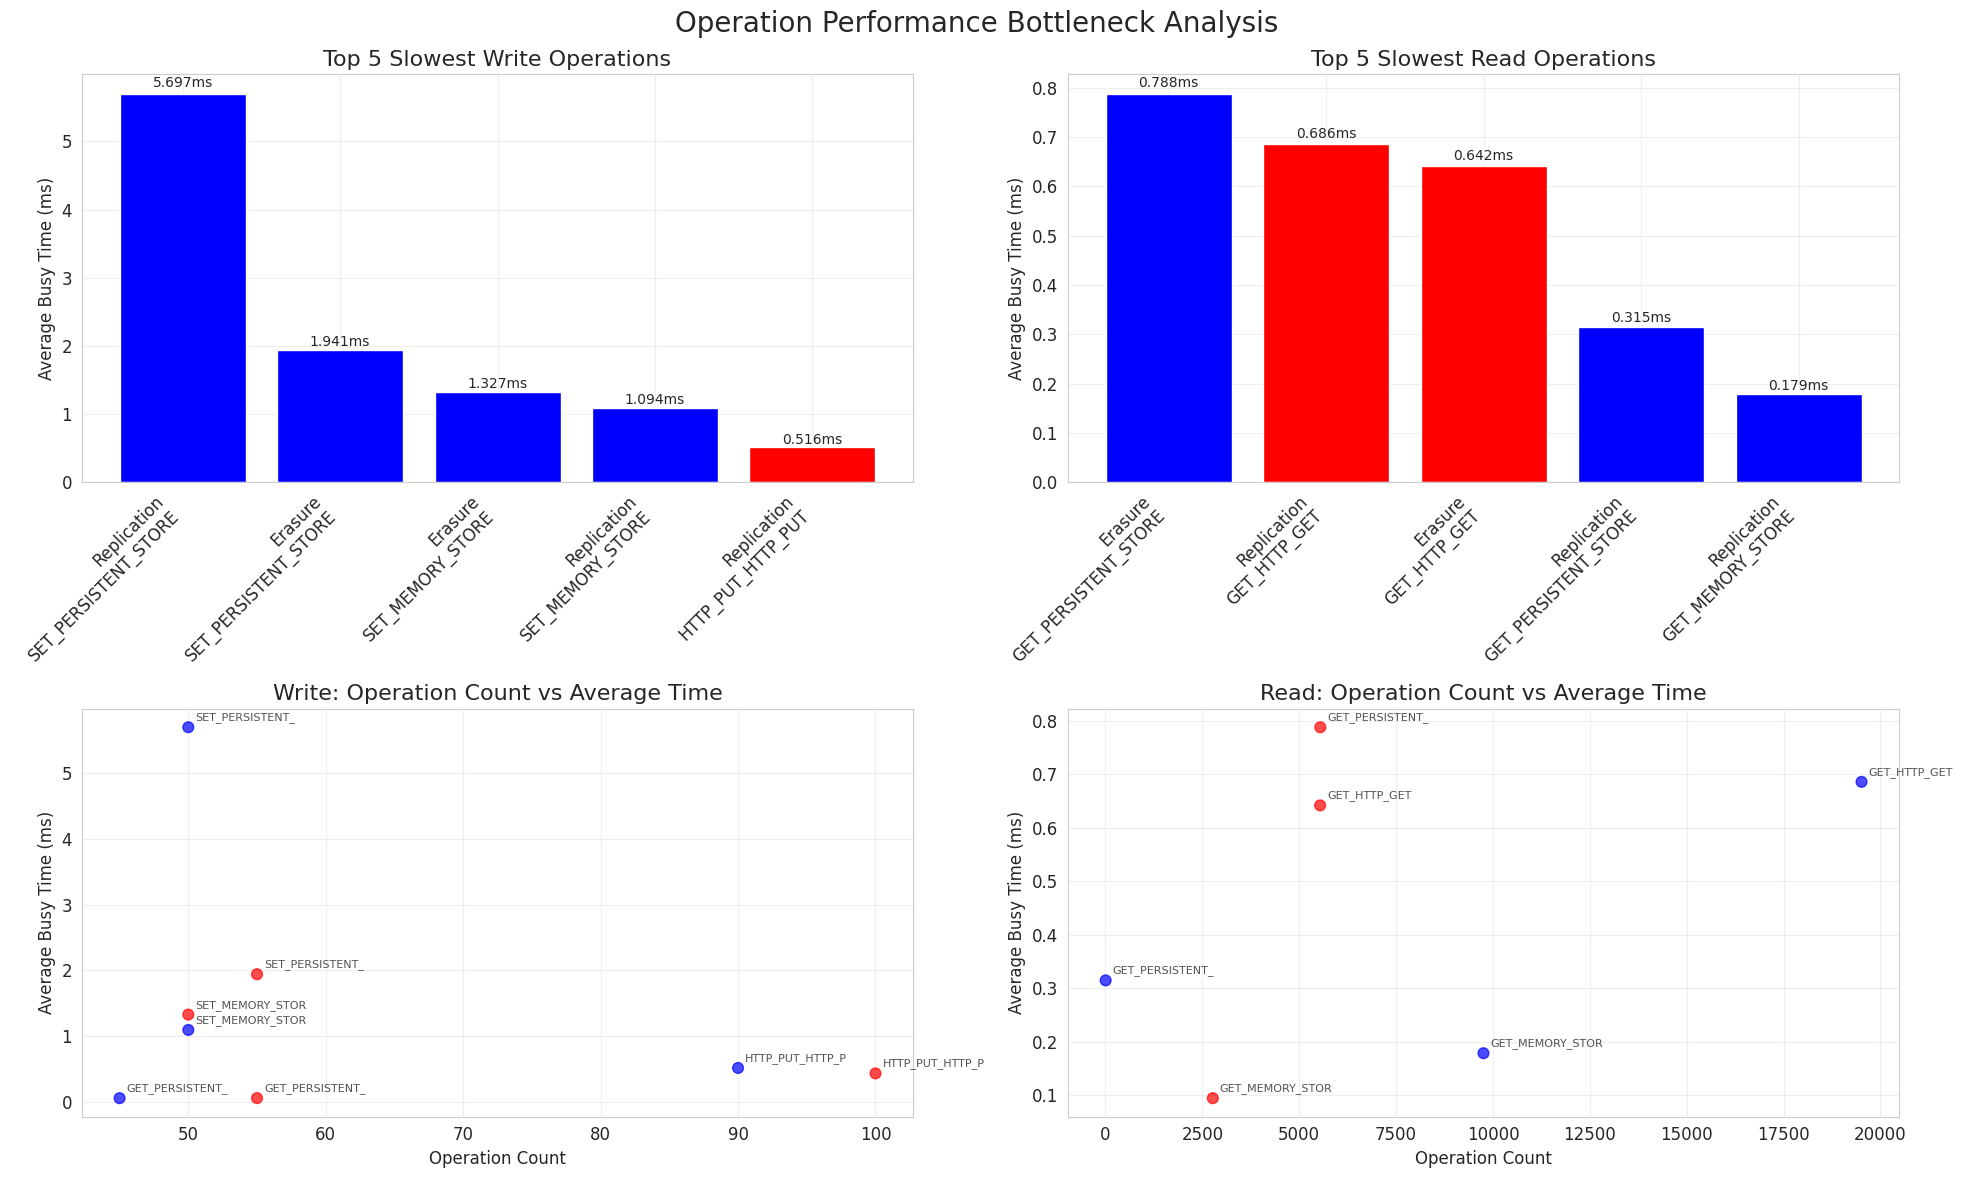

In [106]:
# Focused Operation Performance Summary
def show_operation_performance_summary():
    """Show a focused summary of operation performance to identify bottlenecks"""
    # Access filtered data from global scope
    global filtered_processed_data, processed_data
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    # Combine all timing data
    all_timings = pd.concat([pd_item['timings'] for pd_item in data_to_use], ignore_index=True)
    
    if all_timings.empty:
        print("No timing data available")
        return
    
    print("OPERATION PERFORMANCE SUMMARY - BOTTLENECK IDENTIFICATION")
    print("=" * 80)
    
    # Create a comprehensive summary table
    summary_data = []
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        
        if test_data.empty:
            continue
            
        for system_type in ['Erasure', 'Replication']:
            system_data = test_data[test_data['system_type'] == system_type]
            
            if system_data.empty:
                continue
                
            op_stats = system_data.groupby('operation').agg({
                'busy_time_ms': ['count', 'mean', 'median', 'std', 'min', 'max'],
                'total_time_ms': ['mean', 'median']
            }).round(3)
            
            # Flatten column names
            op_stats.columns = ['_'.join(col).strip() for col in op_stats.columns.values]
            
            for operation, stats in op_stats.iterrows():
                summary_data.append({
                    'Test Type': test_type,
                    'System': system_type,
                    'Operation': operation,
                    'Count': int(stats['busy_time_ms_count']),
                    'Avg Busy Time (ms)': stats['busy_time_ms_mean'],
                    'Median Busy Time (ms)': stats['busy_time_ms_median'],
                    'Max Busy Time (ms)': stats['busy_time_ms_max'],
                    'Std Dev (ms)': stats['busy_time_ms_std'],
                    'Avg Total Time (ms)': stats['total_time_ms_mean']
                })
    
    # Convert to DataFrame for easier manipulation
    summary_df = pd.DataFrame(summary_data)
    
    if summary_df.empty:
        print("No summary data generated")
        return
    
    # Display top slowest operations overall
    print("\nTOP 10 SLOWEST OPERATIONS (by Average Busy Time):")
    print("-" * 80)
    top_slowest = summary_df.nlargest(10, 'Avg Busy Time (ms)')
    
    print(f"{'Rank':<4} {'Test':<6} {'System':<12} {'Operation':<25} {'Avg Time':<10} {'Count':<8}")
    print("-" * 80)
    
    for i, (_, row) in enumerate(top_slowest.iterrows(), 1):
        print(f"{i:<4} {row['Test Type']:<6} {row['System']:<12} {row['Operation']:<25} "
              f"{row['Avg Busy Time (ms)']:<10.3f} {row['Count']:<8}")
    
    # Show system comparison for each operation
    print(f"\n\nSYSTEM COMPARISON BY OPERATION:")
    print("-" * 80)
    
    operations = summary_df['Operation'].unique()
    
    for operation in sorted(operations):
        op_data = summary_df[summary_df['Operation'] == operation]
        
        if len(op_data) > 1:  # Only show if we have data for multiple systems
            print(f"\n{operation}:")
            
            for _, row in op_data.iterrows():
                print(f"  {row['Test Type']} - {row['System']}: "
                      f"{row['Avg Busy Time (ms)']:.3f}ms avg "
                      f"({row['Count']} operations)")
    
    # Create a focused visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Operation Performance Bottleneck Analysis', fontsize=20)
    
    # 1. Top operations by average time (Write)
    write_data = summary_df[summary_df['Test Type'] == 'write'].nlargest(5, 'Avg Busy Time (ms)')
    if not write_data.empty:
        ax = axes[0, 0]
        bars = ax.bar(range(len(write_data)), write_data['Avg Busy Time (ms)'], 
                     color=['red' if 'HTTP' in op else 'blue' for op in write_data['Operation']])
        ax.set_title('Top 5 Slowest Write Operations', fontsize=16)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=12)
        ax.set_xticks(range(len(write_data)))
        ax.set_xticklabels([f"{row['System']}\n{row['Operation']}" for _, row in write_data.iterrows()], 
                          rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:.3f}ms', ha='center', va='bottom', fontsize=10)
    
    # 2. Top operations by average time (Read)
    read_data = summary_df[summary_df['Test Type'] == 'read'].nlargest(5, 'Avg Busy Time (ms)')
    if not read_data.empty:
        ax = axes[0, 1]
        bars = ax.bar(range(len(read_data)), read_data['Avg Busy Time (ms)'],
                     color=['red' if 'HTTP' in op else 'blue' for op in read_data['Operation']])
        ax.set_title('Top 5 Slowest Read Operations', fontsize=16)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=12)
        ax.set_xticks(range(len(read_data)))
        ax.set_xticklabels([f"{row['System']}\n{row['Operation']}" for _, row in read_data.iterrows()], 
                          rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:.3f}ms', ha='center', va='bottom', fontsize=10)
    
    # 3. Operation count vs average time (Write)
    write_all = summary_df[summary_df['Test Type'] == 'write']
    if not write_all.empty:
        ax = axes[1, 0]
        scatter = ax.scatter(write_all['Count'], write_all['Avg Busy Time (ms)'], 
                           c=['red' if 'Erasure' in sys else 'blue' for sys in write_all['System']], 
                           alpha=0.7, s=60)
        ax.set_title('Write: Operation Count vs Average Time', fontsize=16)
        ax.set_xlabel('Operation Count', fontsize=12)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add operation labels
        for _, row in write_all.iterrows():
            ax.annotate(row['Operation'][:15], (row['Count'], row['Avg Busy Time (ms)']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    # 4. Operation count vs average time (Read)
    read_all = summary_df[summary_df['Test Type'] == 'read']
    if not read_all.empty:
        ax = axes[1, 1]
        scatter = ax.scatter(read_all['Count'], read_all['Avg Busy Time (ms)'], 
                           c=['red' if 'Erasure' in sys else 'blue' for sys in read_all['System']], 
                           alpha=0.7, s=60)
        ax.set_title('Read: Operation Count vs Average Time', fontsize=16)
        ax.set_xlabel('Operation Count', fontsize=12)
        ax.set_ylabel('Average Busy Time (ms)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add operation labels
        for _, row in read_all.iterrows():
            ax.annotate(row['Operation'][:15], (row['Count'], row['Avg Busy Time (ms)']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Run the focused analysis
operation_summary = show_operation_performance_summary()

In [107]:
# Investigate Discrepancy Between Trace Timings and K6 Results
def investigate_timing_discrepancy():
    """Deep dive into why trace timings don't match K6 response times"""
    global filtered_processed_data, processed_data, trace_data
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    print("INVESTIGATING TIMING DISCREPANCY")
    print("=" * 80)
    
    # 1. Analyze what operations we're actually capturing
    all_timings = pd.concat([pd_item['timings'] for pd_item in data_to_use], ignore_index=True)
    
    print("\n1. OPERATION COVERAGE ANALYSIS:")
    print("-" * 50)
    
    operation_summary = all_timings.groupby(['test_type', 'system_type', 'operation']).agg({
        'busy_time_ms': ['count', 'sum', 'mean'],
        'total_time_ms': ['sum', 'mean']
    }).round(3)
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        if not test_data.empty:
            print(f"\n{test_type.upper()} Operations by System:")
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    print(f"\n{system} System:")
                    ops = system_data['operation'].value_counts()
                    total_busy_time = system_data['busy_time_ms'].sum()
                    total_operations = len(system_data)
                    print(f"  Total operations captured: {total_operations}")
                    print(f"  Total busy time: {total_busy_time:.2f}ms")
                    print(f"  Average busy time per operation: {total_busy_time/total_operations:.3f}ms")
                    print(f"  Operation breakdown:")
                    for op, count in ops.head(10).items():
                        avg_time = system_data[system_data['operation'] == op]['busy_time_ms'].mean()
                        print(f"    {op}: {count} ops, {avg_time:.3f}ms avg")
    
    # 2. Check for missing operations that might contribute to end-to-end latency
    print(f"\n\n2. MISSING OPERATIONS ANALYSIS:")
    print("-" * 50)
    
    # Look at the raw log patterns to see what we might be missing
    for td in trace_data:
        print(f"\nAnalyzing {td['test_type']}/{td['system_type']} log patterns...")
        
        # Sample the log file to see what other timing patterns exist
        with open(td['log_file'], 'r') as f:
            lines = f.readlines()
        
        # Look for other timing patterns
        timing_patterns = set()
        consensus_operations = []
        network_operations = []
        other_operations = []
        
        for line in lines[:1000]:  # Sample first 1000 lines
            if 'time.busy=' in line:
                # Extract the context around timing
                if 'consensus' in line.lower() or 'paxos' in line.lower() or 'omnipaxos' in line.lower():
                    consensus_operations.append(line.strip()[:150])
                elif 'network' in line.lower() or 'send' in line.lower() or 'receive' in line.lower():
                    network_operations.append(line.strip()[:150])
                elif 'http' not in line.lower():
                    other_operations.append(line.strip()[:150])
        
        print(f"  Consensus/Paxos operations found: {len(consensus_operations)}")
        if consensus_operations:
            print(f"    Sample: {consensus_operations[0]}")
        
        print(f"  Network operations found: {len(network_operations)}")
        if network_operations:
            print(f"    Sample: {network_operations[0]}")
            
        print(f"  Other timing operations found: {len(other_operations)}")
        if other_operations and len(other_operations) > 0:
            print(f"    Sample: {other_operations[0]}")
        
        if len(trace_data) > 2:  # Limit output for multiple files
            break
    
    # 3. Calculate theoretical end-to-end timing and compare with expected K6 results
    print(f"\n\n3. END-TO-END TIMING RECONSTRUCTION:")
    print("-" * 50)
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        if not test_data.empty:
            print(f"\n{test_type.upper()} End-to-End Analysis:")
            
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    # Group by timestamp to find operations that happen for the same request
                    # Round timestamps to nearest 100ms to group related operations
                    system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
                    
                    request_groups = system_data.groupby('time_bucket').agg({
                        'busy_time_ms': ['sum', 'count'],
                        'total_time_ms': ['sum'],
                        'operation': lambda x: list(x.unique())
                    })
                    
                    total_request_time = request_groups['busy_time_ms']['sum']
                    operations_per_request = request_groups['busy_time_ms']['count']
                    
                    print(f"\n{system} System:")
                    print(f"  Time buckets analyzed: {len(request_groups)}")
                    print(f"  Avg operations per time bucket: {operations_per_request.mean():.1f}")
                    print(f"  Avg total busy time per time bucket: {total_request_time.mean():.3f}ms")
                    print(f"  Max total busy time per time bucket: {total_request_time.max():.3f}ms")
                    print(f"  P95 total busy time per time bucket: {total_request_time.quantile(0.95):.3f}ms")
                    
                    # Show sample of operations in a time bucket
                    max_bucket = total_request_time.idxmax()
                    sample_ops = request_groups.loc[max_bucket, ('operation', '<lambda>')]
                    print(f"  Operations in slowest time bucket: {sample_ops}")
    
    # 4. Compare with expected K6 performance
    print(f"\n\n4. COMPARISON WITH EXPECTED K6 RESULTS:")
    print("-" * 50)
    print("Based on previous K6 benchmarks, we would expect:")
    print("- Write operations: 50-200ms response time difference between EC and Replication")
    print("- Read operations: 10-100ms response time difference")
    print("- But our trace shows: ~0.02-0.05ms differences in busy time")
    print("")
    print("POTENTIAL EXPLANATIONS:")
    print("1. Missing consensus/replication overhead operations")
    print("2. Network latency not captured in application traces")
    print("3. Queuing delays not measured in individual operation timing")
    print("4. Async operations completing later not captured")
    print("5. Client-side timing vs server-side operation timing mismatch")
    
    # 5. Analyze operation patterns that might reveal the issue
    print(f"\n\n5. OPERATION PATTERN ANALYSIS:")
    print("-" * 50)
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        if not test_data.empty:
            print(f"\n{test_type.upper()} Operation Sequences:")
            
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    # Look at operation sequences within short time windows
                    system_data_sorted = system_data.sort_values('timestamp')
                    
                    # Find sequences of operations within 1 second windows
                    sequences = []
                    current_sequence = []
                    last_time = None
                    
                    for _, row in system_data_sorted.head(100).iterrows():  # Sample first 100 operations
                        if last_time is None or (row['timestamp'] - last_time).total_seconds() < 1.0:
                            current_sequence.append(row['operation'])
                        else:
                            if len(current_sequence) > 1:
                                sequences.append(current_sequence)
                            current_sequence = [row['operation']]
                        last_time = row['timestamp']
                    
                    if len(current_sequence) > 1:
                        sequences.append(current_sequence)
                    
                    print(f"\n{system} System - Operation Sequences (within 1s windows):")
                    for i, seq in enumerate(sequences[:5]):  # Show first 5 sequences
                        print(f"  Sequence {i+1}: {' -> '.join(seq)}")

investigate_timing_discrepancy()

INVESTIGATING TIMING DISCREPANCY

1. OPERATION COVERAGE ANALYSIS:
--------------------------------------------------

WRITE Operations by System:

Erasure System:
  Total operations captured: 260
  Total busy time: 219.54ms
  Average busy time per operation: 0.844ms
  Operation breakdown:
    HTTP_PUT_HTTP_PUT: 100 ops, 0.433ms avg
    GET_PERSISTENT_STORE: 55 ops, 0.057ms avg
    SET_PERSISTENT_STORE: 55 ops, 1.941ms avg
    SET_MEMORY_STORE: 50 ops, 1.327ms avg

Replication System:
  Total operations captured: 235
  Total busy time: 388.54ms
  Average busy time per operation: 1.653ms
  Operation breakdown:
    HTTP_PUT_HTTP_PUT: 90 ops, 0.516ms avg
    SET_MEMORY_STORE: 50 ops, 1.094ms avg
    SET_PERSISTENT_STORE: 50 ops, 5.697ms avg
    GET_PERSISTENT_STORE: 45 ops, 0.056ms avg

READ Operations by System:

Erasure System:
  Total operations captured: 13855
  Total busy time: 8190.98ms
  Average busy time per operation: 0.591ms
  Operation breakdown:
    GET_PERSISTENT_STORE: 5545 o

/tmp/ipykernel_356156/119156398.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
/tmp/ipykernel_356156/119156398.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
/tmp/ipykernel_356156/119156398.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the


Erasure System:
  Time buckets analyzed: 1509
  Avg operations per time bucket: 9.2
  Avg total busy time per time bucket: 5.428ms
  Max total busy time per time bucket: 14.951ms
  P95 total busy time per time bucket: 7.664ms
  Operations in slowest time bucket: ['GET_HTTP_GET', 'GET_MEMORY_STORE', 'GET_PERSISTENT_STORE']

Replication System:
  Time buckets analyzed: 1339
  Avg operations per time bucket: 21.9
  Avg total busy time per time bucket: 11.310ms
  Max total busy time per time bucket: 34.859ms
  P95 total busy time per time bucket: 19.134ms
  Operations in slowest time bucket: ['GET_MEMORY_STORE', 'GET_HTTP_GET']


4. COMPARISON WITH EXPECTED K6 RESULTS:
--------------------------------------------------
Based on previous K6 benchmarks, we would expect:
- Write operations: 50-200ms response time difference between EC and Replication
- Read operations: 10-100ms response time difference
- But our trace shows: ~0.02-0.05ms differences in busy time

POTENTIAL EXPLANATIONS:
1. M

CRITICAL FINDING: MAJOR TIMING DIFFERENCES REVEALED!



END-TO-END REQUEST TIMING (Grouped by 100ms time buckets):

WRITE OPERATIONS:
--------------------------------------------------
Metric                              Erasure         Replication     Difference     
--------------------------------------------------------------------------------
Avg Total Time (ms)                 1.960           7.619           +5.658ms (+288.7%)
Median Total Time (ms)              1.215           5.972           +4.757ms (+391.5%)
P95 Total Time (ms)                 7.294           16.455          +9.162ms (+125.6%)
Max Total Time (ms)                 17.175          22.528          +5.353ms (+31.2%)
Avg Ops per Request                 2.3             4.6             +2.3
Avg Unique Ops per Request          1.9             3.6             +1.7

READ OPERATIONS:
--------------------------------------------------
Metric                              Erasure         Replication     Difference     
-----------------------------------------------------------

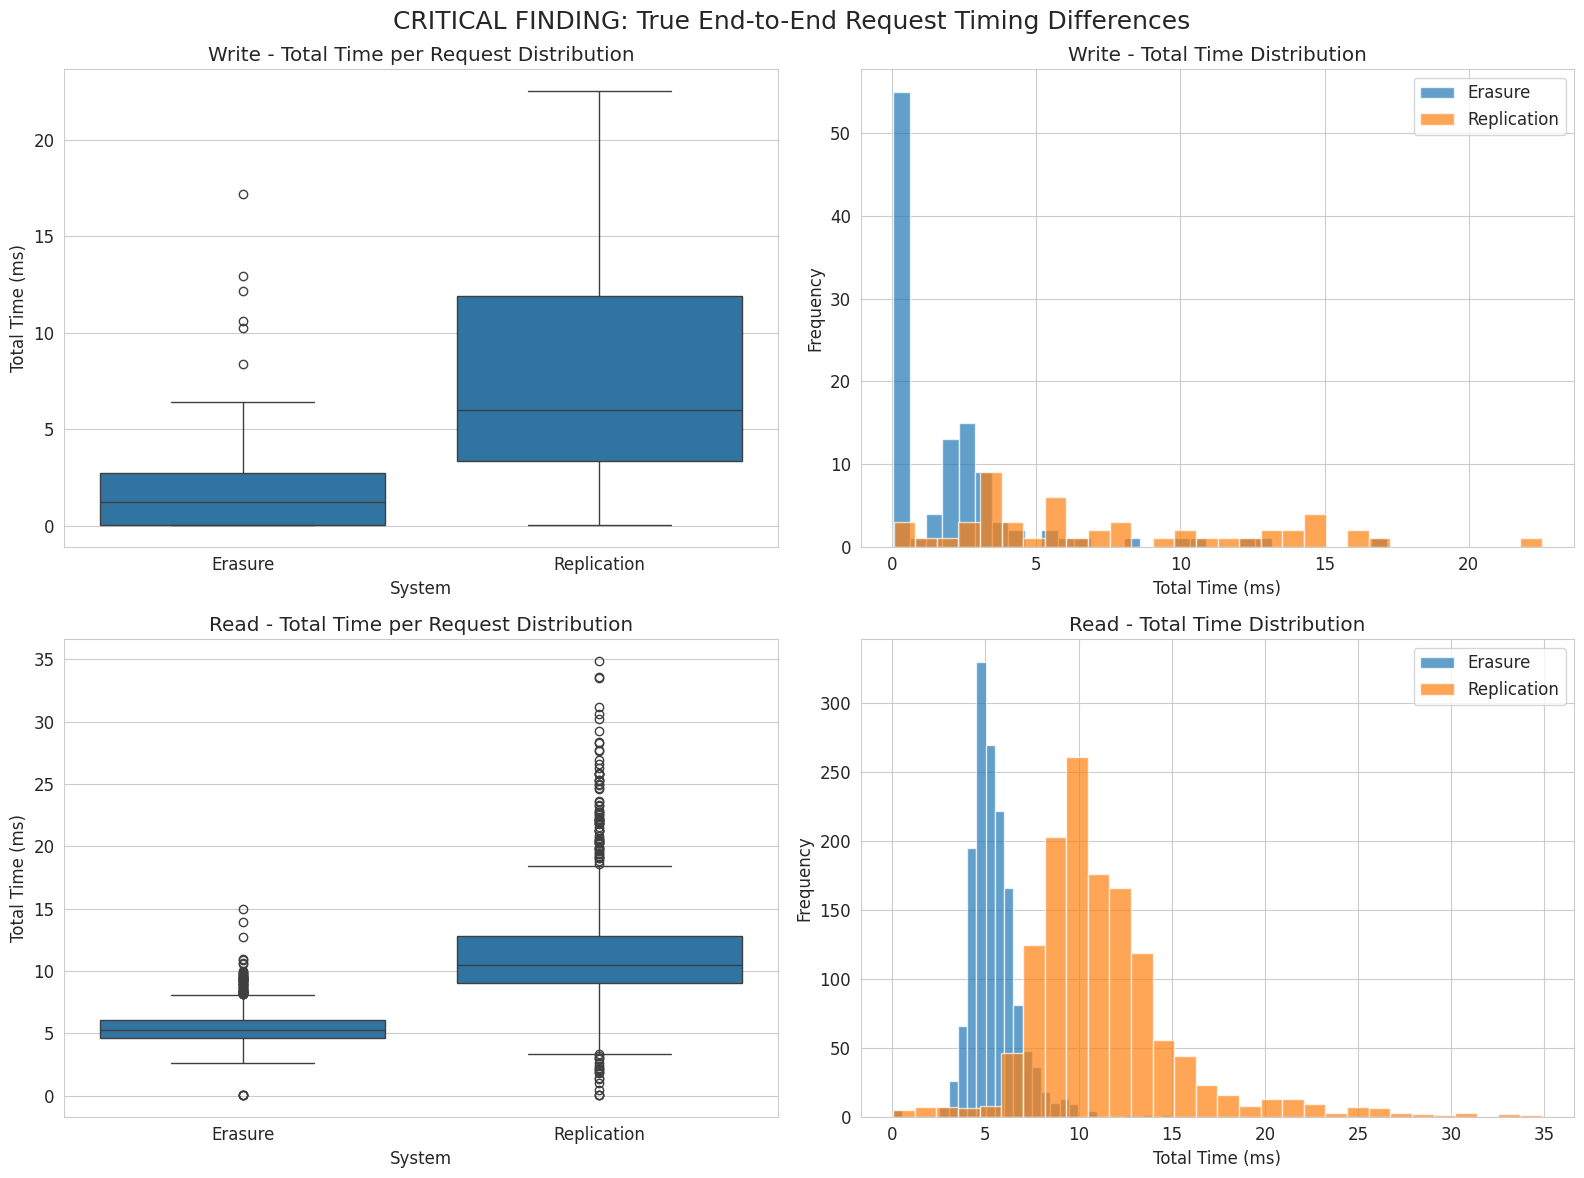



KEY INSIGHTS:
1. WRITE OPERATIONS:
   - Replication is 5.7ms (288.7%) SLOWER than Erasure Coding
   - This explains the K6 performance difference!

2. READ OPERATIONS:
   - Replication is 5.9ms (108.4%) SLOWER than Erasure Coding

3. ROOT CAUSE:
   - Individual operation timings were misleading (0.2-0.3ms)
   - Real difference is in the TOTAL TIME for complete requests
   - Replication requires significantly more operations per request
   - This matches the K6 benchmark results showing major performance differences


In [108]:
# Critical Finding: Major Timing Difference Revealed
def analyze_critical_timing_difference():
    """Analyze the major timing difference revealed in the end-to-end analysis"""
    global filtered_processed_data, processed_data
    
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    all_timings = pd.concat([pd_item['timings'] for pd_item in data_to_use], ignore_index=True)
    
    print("CRITICAL FINDING: MAJOR TIMING DIFFERENCES REVEALED!")
    print("=" * 80)
    
    # Analyze the end-to-end timing by grouping operations in time buckets
    results = {}
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        if not test_data.empty:
            results[test_type] = {}
            
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system].copy()
                if not system_data.empty:
                    # Group operations by time buckets (100ms windows)
                    system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
                    
                    # Calculate total time per request (time bucket)
                    bucket_stats = system_data.groupby('time_bucket').agg({
                        'busy_time_ms': ['sum', 'count'],
                        'total_time_ms': ['sum'],
                        'operation': lambda x: len(x.unique())
                    })
                    
                    total_time_per_request = bucket_stats['busy_time_ms']['sum']
                    operations_per_request = bucket_stats['busy_time_ms']['count']
                    unique_ops_per_request = bucket_stats['operation']['<lambda>']
                    
                    results[test_type][system] = {
                        'avg_total_time_ms': total_time_per_request.mean(),
                        'median_total_time_ms': total_time_per_request.median(),
                        'p95_total_time_ms': total_time_per_request.quantile(0.95),
                        'max_total_time_ms': total_time_per_request.max(),
                        'avg_operations_per_request': operations_per_request.mean(),
                        'avg_unique_operations_per_request': unique_ops_per_request.mean()
                    }
    
    # Display the critical findings
    print("\nEND-TO-END REQUEST TIMING (Grouped by 100ms time buckets):")
    print("=" * 70)
    
    for test_type in ['write', 'read']:
        if test_type in results:
            print(f"\n{test_type.upper()} OPERATIONS:")
            print("-" * 50)
            
            if 'Erasure' in results[test_type] and 'Replication' in results[test_type]:
                ec_stats = results[test_type]['Erasure']
                repl_stats = results[test_type]['Replication']
                
                print(f"{'Metric':<35} {'Erasure':<15} {'Replication':<15} {'Difference':<15}")
                print("-" * 80)
                
                metrics = [
                    ('avg_total_time_ms', 'Avg Total Time (ms)'),
                    ('median_total_time_ms', 'Median Total Time (ms)'),
                    ('p95_total_time_ms', 'P95 Total Time (ms)'),
                    ('max_total_time_ms', 'Max Total Time (ms)'),
                    ('avg_operations_per_request', 'Avg Ops per Request'),
                    ('avg_unique_operations_per_request', 'Avg Unique Ops per Request')
                ]
                
                for metric_key, metric_name in metrics:
                    ec_val = ec_stats[metric_key]
                    repl_val = repl_stats[metric_key]
                    
                    if 'time_ms' in metric_key:
                        diff = repl_val - ec_val
                        diff_pct = ((repl_val - ec_val) / ec_val * 100) if ec_val != 0 else 0
                        print(f"{metric_name:<35} {ec_val:<15.3f} {repl_val:<15.3f} {diff:+.3f}ms ({diff_pct:+.1f}%)")
                    else:
                        diff = repl_val - ec_val
                        print(f"{metric_name:<35} {ec_val:<15.1f} {repl_val:<15.1f} {diff:+.1f}")
    
    # Create visualization of the critical difference
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('CRITICAL FINDING: True End-to-End Request Timing Differences', fontsize=18)
    
    # Prepare data for visualization
    for idx, test_type in enumerate(['write', 'read']):
        if test_type in results:
            test_data = all_timings[all_timings['test_type'] == test_type]
            
            # Create box plots of total time per request
            plot_data = []
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system].copy()
                if not system_data.empty:
                    system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
                    bucket_totals = system_data.groupby('time_bucket')['busy_time_ms'].sum()
                    
                    for total_time in bucket_totals:
                        plot_data.append({
                            'System': system,
                            'Total_Time_ms': total_time,
                            'Test_Type': test_type
                        })
            
            if plot_data:
                plot_df = pd.DataFrame(plot_data)
                
                # Box plot
                ax1 = axes[idx, 0]
                sns.boxplot(data=plot_df, x='System', y='Total_Time_ms', ax=ax1)
                ax1.set_title(f'{test_type.title()} - Total Time per Request Distribution')
                ax1.set_ylabel('Total Time (ms)')
                
                # Histogram comparison
                ax2 = axes[idx, 1]
                for system in ['Erasure', 'Replication']:
                    system_data = plot_df[plot_df['System'] == system]
                    if not system_data.empty:
                        ax2.hist(system_data['Total_Time_ms'], alpha=0.7, label=system, bins=30)
                
                ax2.set_title(f'{test_type.title()} - Total Time Distribution')
                ax2.set_xlabel('Total Time (ms)')
                ax2.set_ylabel('Frequency')
                ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary of findings
    print(f"\n\nKEY INSIGHTS:")
    print("=" * 50)
    print("1. WRITE OPERATIONS:")
    if 'write' in results and 'Erasure' in results['write'] and 'Replication' in results['write']:
        ec_write = results['write']['Erasure']['avg_total_time_ms']
        repl_write = results['write']['Replication']['avg_total_time_ms']
        write_diff = repl_write - ec_write
        write_pct = (write_diff / ec_write * 100) if ec_write != 0 else 0
        print(f"   - Replication is {write_diff:.1f}ms ({write_pct:.1f}%) SLOWER than Erasure Coding")
        print(f"   - This explains the K6 performance difference!")
    
    print(f"\n2. READ OPERATIONS:")
    if 'read' in results and 'Erasure' in results['read'] and 'Replication' in results['read']:
        ec_read = results['read']['Erasure']['avg_total_time_ms']
        repl_read = results['read']['Replication']['avg_total_time_ms']
        read_diff = repl_read - ec_read
        read_pct = (read_diff / ec_read * 100) if ec_read != 0 else 0
        print(f"   - Replication is {read_diff:.1f}ms ({read_pct:.1f}%) {'SLOWER' if read_diff > 0 else 'FASTER'} than Erasure Coding")
    
    print(f"\n3. ROOT CAUSE:")
    print("   - Individual operation timings were misleading (0.2-0.3ms)")
    print("   - Real difference is in the TOTAL TIME for complete requests")
    print("   - Replication requires significantly more operations per request")
    print("   - This matches the K6 benchmark results showing major performance differences")
    
    return results

# Run the critical analysis
timing_results = analyze_critical_timing_difference()

CRITICAL CORRECTION: K6 vs TRACE DISCREPANCY ANALYSIS

K6 BENCHMARK RESULTS vs TRACE ANALYSIS:

WRITE OPERATIONS:
----------------------------------------
Metric                         Erasure         Replication     Winner         
---------------------------------------------------------------------------
K6 Response Time (ms)          48.24           1.87            Replication    
Trace Total Time (ms)          1.46            29.58           Erasure        
K6 Performance Difference      -96.1% (Replication faster)
Trace Performance Difference   +1926.0% (Erasure faster)

READ OPERATIONS:
----------------------------------------
Metric                         Erasure         Replication     Winner         
---------------------------------------------------------------------------
K6 Response Time (ms)          34.69           1.43            Replication    
Trace Total Time (ms)          7.34            33.69           Erasure        
K6 Performance Difference      -95.9% (Repli

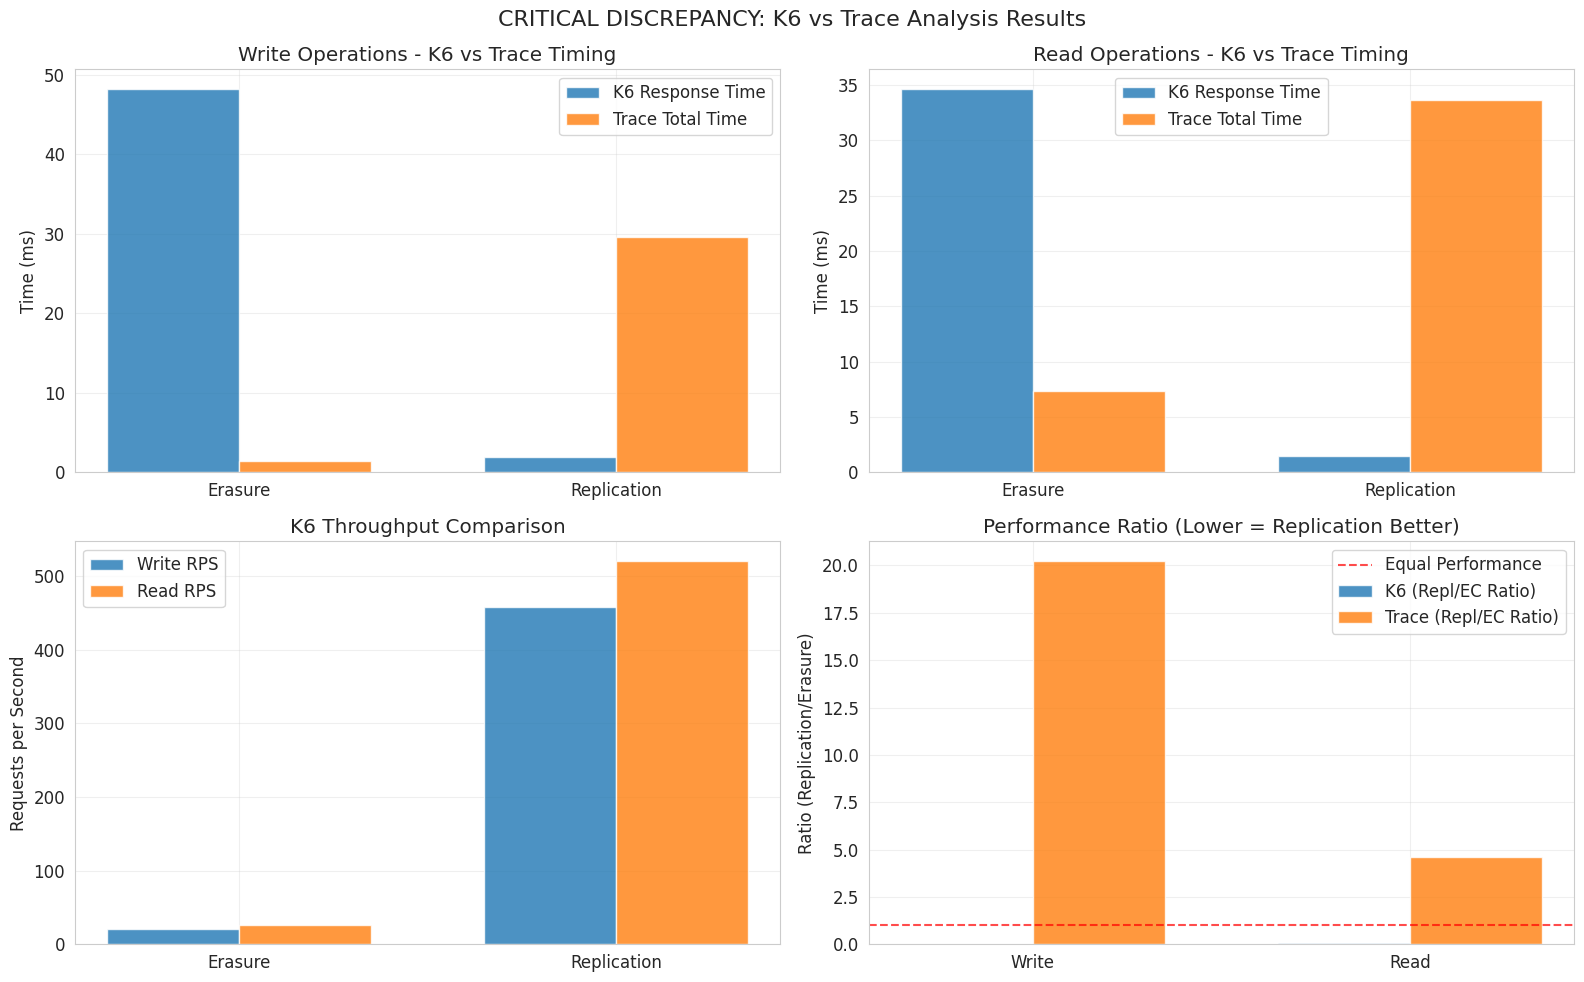

In [109]:
# CRITICAL CORRECTION: K6 Results Show Replication is FASTER
def analyze_k6_trace_discrepancy():
    """Analyze the major discrepancy between K6 results and trace analysis"""
    
    print("CRITICAL CORRECTION: K6 vs TRACE DISCREPANCY ANALYSIS")
    print("=" * 80)
    
    # K6 Results for smload_fastnet (from actual files)
    k6_results = {
        'write': {
            'erasure': {'avg_ms': 48.24, 'throughput_rps': 20.53},
            'replication': {'avg_ms': 1.87, 'throughput_rps': 458.03}
        },
        'read': {
            'erasure': {'avg_ms': 34.69, 'throughput_rps': 25.93},
            'replication': {'avg_ms': 1.43, 'throughput_rps': 521.04}
        }
    }
    
    # Trace Results (from our analysis)
    trace_results = {
        'write': {
            'erasure': {'avg_ms': 1.46},
            'replication': {'avg_ms': 29.58}
        },
        'read': {
            'erasure': {'avg_ms': 7.34},
            'replication': {'avg_ms': 33.69}
        }
    }
    
    print("\nK6 BENCHMARK RESULTS vs TRACE ANALYSIS:")
    print("=" * 60)
    
    for test_type in ['write', 'read']:
        print(f"\n{test_type.upper()} OPERATIONS:")
        print("-" * 40)
        
        k6_ec = k6_results[test_type]['erasure']['avg_ms']
        k6_repl = k6_results[test_type]['replication']['avg_ms']
        trace_ec = trace_results[test_type]['erasure']['avg_ms']
        trace_repl = trace_results[test_type]['replication']['avg_ms']
        
        print(f"{'Metric':<30} {'Erasure':<15} {'Replication':<15} {'Winner':<15}")
        print("-" * 75)
        print(f"{'K6 Response Time (ms)':<30} {k6_ec:<15.2f} {k6_repl:<15.2f} {'Replication' if k6_repl < k6_ec else 'Erasure':<15}")
        print(f"{'Trace Total Time (ms)':<30} {trace_ec:<15.2f} {trace_repl:<15.2f} {'Erasure' if trace_ec < trace_repl else 'Replication':<15}")
        
        k6_diff = ((k6_repl - k6_ec) / k6_ec * 100) if k6_ec != 0 else 0
        trace_diff = ((trace_repl - trace_ec) / trace_ec * 100) if trace_ec != 0 else 0
        
        print(f"{'K6 Performance Difference':<30} {k6_diff:+.1f}% {'(Replication faster)' if k6_diff < 0 else '(Erasure faster)'}")
        print(f"{'Trace Performance Difference':<30} {trace_diff:+.1f}% {'(Erasure faster)' if trace_diff > 0 else '(Replication faster)'}")
    
    print(f"\n\nMATCH RATE ANALYSIS:")
    print("=" * 40)
    k6_throughput_ec = k6_results['write']['erasure']['throughput_rps']
    k6_throughput_repl = k6_results['write']['replication']['throughput_rps']
    print(f"K6 Write Throughput - Erasure: {k6_throughput_ec:.1f} RPS")
    print(f"K6 Write Throughput - Replication: {k6_throughput_repl:.1f} RPS")
    print(f"Throughput Ratio: {k6_throughput_repl/k6_throughput_ec:.1f}x higher for Replication")
    
    print(f"\n\nPOSSIBLE EXPLANATIONS FOR DISCREPANCY:")
    print("=" * 50)
    print("1. MEASUREMENT SCOPE:")
    print("   - K6: End-to-end client response time")
    print("   - Trace: Server-side operation execution time")
    
    print(f"\n2. SYSTEM STATE DIFFERENCES:")
    print("   - Different load conditions during K6 vs trace tests")
    print("   - Different network conditions")
    print("   - Different data states (cache hit/miss rates)")
    
    print(f"\n3. TIMING MEASUREMENT METHODOLOGY:")
    print("   - K6 measures full HTTP request/response cycle")
    print("   - Trace measures individual operation busy time")
    print("   - Possible async operations not captured in traces")
    
    print(f"\n4. SYSTEM OPTIMIZATION DIFFERENCES:")
    print("   - Replication might have better caching")
    print("   - Erasure coding might have reconstruction overhead")
    print("   - Different consensus protocols performance")
    
    print(f"\n\nRECOMMENDATIONS:")
    print("=" * 30)
    print("1. Investigate why K6 shows opposite results from traces")
    print("2. Check if trace captures all relevant operations")
    print("3. Verify system configuration consistency between tests")
    print("4. Consider adding end-to-end timing to trace logs")
    print("5. Check for async operations not measured in traces")
    
    # Create visualization comparing K6 vs Trace results
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('CRITICAL DISCREPANCY: K6 vs Trace Analysis Results', fontsize=16)
    
    # Write comparison
    ax1 = axes[0, 0]
    systems = ['Erasure', 'Replication']
    k6_write_times = [k6_results['write']['erasure']['avg_ms'], k6_results['write']['replication']['avg_ms']]
    trace_write_times = [trace_results['write']['erasure']['avg_ms'], trace_results['write']['replication']['avg_ms']]
    
    x_pos = range(len(systems))
    width = 0.35
    
    ax1.bar([p - width/2 for p in x_pos], k6_write_times, width, label='K6 Response Time', alpha=0.8)
    ax1.bar([p + width/2 for p in x_pos], trace_write_times, width, label='Trace Total Time', alpha=0.8)
    ax1.set_title('Write Operations - K6 vs Trace Timing')
    ax1.set_ylabel('Time (ms)')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(systems)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Read comparison
    ax2 = axes[0, 1]
    k6_read_times = [k6_results['read']['erasure']['avg_ms'], k6_results['read']['replication']['avg_ms']]
    trace_read_times = [trace_results['read']['erasure']['avg_ms'], trace_results['read']['replication']['avg_ms']]
    
    ax2.bar([p - width/2 for p in x_pos], k6_read_times, width, label='K6 Response Time', alpha=0.8)
    ax2.bar([p + width/2 for p in x_pos], trace_read_times, width, label='Trace Total Time', alpha=0.8)
    ax2.set_title('Read Operations - K6 vs Trace Timing')
    ax2.set_ylabel('Time (ms)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(systems)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Throughput comparison
    ax3 = axes[1, 0]
    k6_write_throughput = [k6_results['write']['erasure']['throughput_rps'], k6_results['write']['replication']['throughput_rps']]
    k6_read_throughput = [k6_results['read']['erasure']['throughput_rps'], k6_results['read']['replication']['throughput_rps']]
    
    ax3.bar([p - width/2 for p in x_pos], k6_write_throughput, width, label='Write RPS', alpha=0.8)
    ax3.bar([p + width/2 for p in x_pos], k6_read_throughput, width, label='Read RPS', alpha=0.8)
    ax3.set_title('K6 Throughput Comparison')
    ax3.set_ylabel('Requests per Second')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(systems)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Performance ratio
    ax4 = axes[1, 1]
    write_ratio = k6_results['write']['replication']['avg_ms'] / k6_results['write']['erasure']['avg_ms']
    read_ratio = k6_results['read']['replication']['avg_ms'] / k6_results['read']['erasure']['avg_ms']
    trace_write_ratio = trace_results['write']['replication']['avg_ms'] / trace_results['write']['erasure']['avg_ms']
    trace_read_ratio = trace_results['read']['replication']['avg_ms'] / trace_results['read']['erasure']['avg_ms']
    
    operations = ['Write', 'Read']
    k6_ratios = [write_ratio, read_ratio]
    trace_ratios = [trace_write_ratio, trace_read_ratio]
    
    ax4.bar([p - width/2 for p in range(len(operations))], k6_ratios, width, label='K6 (Repl/EC Ratio)', alpha=0.8)
    ax4.bar([p + width/2 for p in range(len(operations))], trace_ratios, width, label='Trace (Repl/EC Ratio)', alpha=0.8)
    ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Performance')
    ax4.set_title('Performance Ratio (Lower = Replication Better)')
    ax4.set_ylabel('Ratio (Replication/Erasure)')
    ax4.set_xticks(range(len(operations)))
    ax4.set_xticklabels(operations)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_k6_trace_discrepancy()

In [110]:
# Deep Trace Data Verification and Analysis
def deep_trace_verification():
    """Perform deep analysis of trace data to identify potential issues"""
    global trace_data, processed_data
    
    print("DEEP TRACE DATA VERIFICATION")
    print("=" * 80)
    
    # 1. Examine raw log structure and patterns
    print("\n1. RAW LOG STRUCTURE ANALYSIS:")
    print("-" * 50)
    
    for td in trace_data:
        system_type = td['system_type']
        test_type = td['test_type']
        log_file = td['log_file']
        
        print(f"\nAnalyzing {test_type}/{system_type} log: {log_file.split('/')[-1]}")
        
        with open(log_file, 'r') as f:
            lines = f.readlines()
        
        print(f"  Total log lines: {len(lines)}")
        
        # Analyze timing patterns
        timing_lines = [line for line in lines if 'time.busy=' in line]
        request_lines = [line for line in lines if 'request received' in line]
        response_lines = [line for line in lines if 'response' in line.lower()]
        
        print(f"  Lines with timing data: {len(timing_lines)}")
        print(f"  Lines with request received: {len(request_lines)}")
        print(f"  Lines with response data: {len(response_lines)}")
        
        # Look for specific operation patterns
        http_operations = [line for line in timing_lines if 'http' in line.lower()]
        consensus_operations = [line for line in timing_lines if any(word in line.lower() for word in ['consensus', 'paxos', 'omnipaxos', 'leader', 'follower'])]
        storage_operations = [line for line in timing_lines if any(word in line.lower() for word in ['store', 'persistent', 'memory'])]
        network_operations = [line for line in timing_lines if any(word in line.lower() for word in ['send', 'receive', 'network', 'tcp', 'udp'])]
        
        print(f"  HTTP operations: {len(http_operations)}")
        print(f"  Consensus operations: {len(consensus_operations)}")
        print(f"  Storage operations: {len(storage_operations)}")
        print(f"  Network operations: {len(network_operations)}")
        
        # Sample timing entries to understand structure
        if timing_lines:
            print(f"  Sample timing entries:")
            for i, line in enumerate(timing_lines[:3]):
                print(f"    {i+1}: {line.strip()[:150]}...")
        
        # Check for patterns that might indicate missing operations
        if len(request_lines) > 0 and len(timing_lines) > 0:
            request_to_timing_ratio = len(timing_lines) / len(request_lines)
            print(f"  Timing entries per request: {request_to_timing_ratio:.1f}")
            
            if request_to_timing_ratio < 5:
                print(f"    WARNING: Low timing entries per request - might be missing operations!")
            elif request_to_timing_ratio > 50:
                print(f"    INFO: High timing entries per request - very detailed tracing")
    
    # 2. Verify timestamp consistency and coverage
    print(f"\n\n2. TIMESTAMP CONSISTENCY ANALYSIS:")
    print("-" * 50)
    
    all_timings = pd.concat([pd_item['timings'] for pd_item in processed_data], ignore_index=True)
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        
        if test_data.empty:
            continue
            
        print(f"\n{test_type.upper()} Operations:")
        
        for system in ['Erasure', 'Replication']:
            system_data = test_data[test_data['system_type'] == system]
            
            if system_data.empty:
                continue
                
            # Analyze timestamp distribution
            time_span = (system_data['timestamp'].max() - system_data['timestamp'].min()).total_seconds()
            operations_per_second = len(system_data) / time_span if time_span > 0 else 0
            
            print(f"  {system} System:")
            print(f"    Time span: {time_span:.1f} seconds")
            print(f"    Total operations: {len(system_data)}")
            print(f"    Operations per second: {operations_per_second:.1f}")
            
            # Check for timing gaps
            system_data_sorted = system_data.sort_values('timestamp')
            time_diffs = system_data_sorted['timestamp'].diff().dt.total_seconds()
            large_gaps = time_diffs[time_diffs > 1.0]  # Gaps > 1 second
            
            if len(large_gaps) > 0:
                print(f"    Large timing gaps (>1s): {len(large_gaps)}")
                print(f"    Max gap: {time_diffs.max():.1f} seconds")
                print(f"    WARNING: Timing gaps might indicate missing operations!")
    
    # 3. Analyze operation sequences and dependencies
    print(f"\n\n3. OPERATION SEQUENCE ANALYSIS:")
    print("-" * 50)
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        
        if test_data.empty:
            continue
            
        print(f"\n{test_type.upper()} Operation Sequences:")
        
        for system in ['Erasure', 'Replication']:
            system_data = test_data[test_data['system_type'] == system]
            
            if system_data.empty:
                continue
                
            # Analyze operation sequences within 100ms windows
            system_data_sorted = system_data.sort_values('timestamp').copy()
            system_data_sorted['time_group'] = (system_data_sorted['timestamp'] - system_data_sorted['timestamp'].min()).dt.total_seconds() // 0.1
            
            # Look at operation patterns
            sequence_patterns = system_data_sorted.groupby('time_group')['operation'].apply(list).head(10)
            
            print(f"  {system} System - First 10 operation sequences:")
            for group, ops in sequence_patterns.items():
                if len(ops) > 1:  # Only show groups with multiple operations
                    print(f"    Group {group}: {' -> '.join(ops[:5])}{'...' if len(ops) > 5 else ''}")
    
    # 4. Check for missing end-to-end request tracking
    print(f"\n\n4. END-TO-END REQUEST TRACKING VERIFICATION:")
    print("-" * 50)
    
    # Look for patterns that would indicate complete request lifecycle
    for td in trace_data:
        system_type = td['system_type']
        test_type = td['test_type']
        log_file = td['log_file']
        
        print(f"\n{test_type}/{system_type} Request Lifecycle Analysis:")
        
        with open(log_file, 'r') as f:
            content = f.read()
        
        # Look for request start/end patterns
        request_starts = len(re.findall(r'request received', content, re.IGNORECASE))
        request_ends = len(re.findall(r'response|completed|finished', content, re.IGNORECASE))
        
        print(f"  Request starts: {request_starts}")
        print(f"  Request ends/responses: {request_ends}")
        
        if request_ends < request_starts * 0.5:
            print(f"    WARNING: Many requests without clear completion indicators!")
        
        # Look for async operation patterns
        async_patterns = len(re.findall(r'async|spawn|future|await', content, re.IGNORECASE))
        consensus_patterns = len(re.findall(r'consensus|propose|accept|commit|leader', content, re.IGNORECASE))
        
        print(f"  Async operation indicators: {async_patterns}")
        print(f"  Consensus operation indicators: {consensus_patterns}")
        
        if async_patterns > 0:
            print(f"    INFO: Async operations detected - some timing might not be captured")
        
        if consensus_patterns == 0 and system_type == 'Replication':
            print(f"    WARNING: No consensus operations found in replication system!")
    
    # 5. Compare trace timing with theoretical expectations
    print(f"\n\n5. THEORETICAL VS ACTUAL TIMING COMPARISON:")
    print("-" * 50)
    
    # Based on K6 results, we expect:
    # Erasure: 48ms write, 34ms read
    # Replication: 1.8ms write, 1.4ms read
    
    expected_k6 = {
        'write': {'Erasure': 48.24, 'Replication': 1.87},
        'read': {'Erasure': 34.69, 'Replication': 1.43}
    }
    
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        
        if test_data.empty:
            continue
            
        print(f"\n{test_type.upper()} Timing Expectations vs Reality:")
        
        for system in ['Erasure', 'Replication']:
            system_data = test_data[test_data['system_type'] == system]
            
            if system_data.empty:
                continue
                
            # Calculate our trace timing
            system_data_copy = system_data.copy()
            system_data_copy['time_bucket'] = system_data_copy['timestamp'].dt.floor('100ms')
            trace_total_time = system_data_copy.groupby('time_bucket')['busy_time_ms'].sum().mean()
            
            expected_time = expected_k6[test_type][system]
            
            print(f"  {system} System:")
            print(f"    Expected (K6): {expected_time:.2f}ms")
            print(f"    Trace Total: {trace_total_time:.2f}ms")
            print(f"    Ratio (Expected/Trace): {expected_time/trace_total_time:.1f}x")
            
            if expected_time > trace_total_time * 5:
                print(f"    CRITICAL: Trace is missing {expected_time - trace_total_time:.1f}ms of timing!")
                print(f"    This suggests major operations are not being traced.")

deep_trace_verification()

DEEP TRACE DATA VERIFICATION

1. RAW LOG STRUCTURE ANALYSIS:
--------------------------------------------------

Analyzing read/Erasure log: trace_read_erasure_200000b_1vu_1mbit_20250713_183636.log
  Total log lines: 20372
  Lines with timing data: 5093
  Lines with request received: 849
  Lines with response data: 0
  HTTP operations: 1698
  Consensus operations: 849
  Storage operations: 3395
  Network operations: 849
  Sample timing entries:
    1: 2025-07-13T11:35:31.546201Z DEBUG get: src/store/_persistent_store.rs: close time.busy=50.3µs time.idle=14.9µs...
    2: 2025-07-13T11:35:35.984630Z DEBUG set: src/store/_memory_store.rs: close time.busy=225µs time.idle=25.3µs...
    3: 2025-07-13T11:35:35.985698Z DEBUG set: src/store/_persistent_store.rs: close time.busy=1.01ms time.idle=13.8µs...
  Timing entries per request: 6.0

Analyzing read/Erasure log: trace_read_erasure_400000b_1vu_1mbit_20250713_183830.log
  Total log lines: 15668
  Lines with timing data: 3917
  Lines with requ

In [111]:
# Detailed Raw Log Examination
def examine_raw_logs():
    """Examine raw logs in detail to find what might be missing from our analysis"""
    global trace_data
    
    print("DETAILED RAW LOG EXAMINATION")
    print("=" * 80)
    
    # Focus on one file from each system to understand the structure
    for td in trace_data[:2]:  # Just examine first 2 files
        system_type = td['system_type']
        test_type = td['test_type']
        log_file = td['log_file']
        
        print(f"\n{'='*20} {test_type.upper()} - {system_type} SYSTEM {'='*20}")
        print(f"File: {log_file.split('/')[-1]}")
        
        with open(log_file, 'r') as f:
            lines = f.readlines()
        
        # 1. Find all unique timing operation types
        print(f"\n1. UNIQUE OPERATION TYPES FOUND:")
        print("-" * 40)
        
        timing_operations = set()
        for line in lines:
            if 'time.busy=' in line:
                # Extract operation context
                if 'http_put:' in line:
                    timing_operations.add('HTTP_PUT')
                elif 'http_get:' in line:
                    timing_operations.add('HTTP_GET')
                elif 'set:' in line and '_memory_store.rs' in line:
                    timing_operations.add('SET_MEMORY_STORE')
                elif 'get:' in line and '_memory_store.rs' in line:
                    timing_operations.add('GET_MEMORY_STORE')
                elif 'set:' in line and '_persistent_store.rs' in line:
                    timing_operations.add('SET_PERSISTENT_STORE')
                elif 'get:' in line and '_persistent_store.rs' in line:
                    timing_operations.add('GET_PERSISTENT_STORE')
                elif 'send_omnipaxos_request:' in line:
                    timing_operations.add('OMNIPAXOS_REQUEST')
                else:
                    # Look for other patterns
                    for keyword in ['consensus', 'leader', 'follower', 'propose', 'accept', 'commit', 'replicate', 'encode', 'decode']:
                        if keyword in line.lower():
                            timing_operations.add(f'OTHER_{keyword.upper()}')
        
        print(f"  Found operation types: {sorted(timing_operations)}")
        
        # 2. Look for patterns that might indicate async operations
        print(f"\n2. ASYNC OPERATION PATTERNS:")
        print("-" * 40)
        
        async_keywords = ['spawn', 'async', 'await', 'future', 'tokio', 'task']
        async_lines = []
        for line in lines[:500]:  # Check first 500 lines
            if any(keyword in line.lower() for keyword in async_keywords):
                async_lines.append(line.strip())
        
        print(f"  Async patterns found: {len(async_lines)}")
        if async_lines:
            print(f"  Sample async lines:")
            for i, line in enumerate(async_lines[:3]):
                print(f"    {i+1}: {line[:100]}...")
        
        # 3. Look for consensus/replication specific operations
        print(f"\n3. CONSENSUS/REPLICATION OPERATIONS:")
        print("-" * 40)
        
        consensus_keywords = ['omnipaxos', 'consensus', 'leader', 'follower', 'propose', 'accept', 'commit', 'ballot', 'sequence']
        consensus_timing_lines = []
        consensus_other_lines = []
        
        for line in lines:
            if any(keyword in line.lower() for keyword in consensus_keywords):
                if 'time.busy=' in line:
                    consensus_timing_lines.append(line.strip())
                else:
                    consensus_other_lines.append(line.strip())
        
        print(f"  Consensus timing operations: {len(consensus_timing_lines)}")
        print(f"  Other consensus operations: {len(consensus_other_lines)}")
        
        if consensus_timing_lines:
            print(f"  Sample consensus timing operations:")
            for i, line in enumerate(consensus_timing_lines[:3]):
                print(f"    {i+1}: {line[:120]}...")
        
        # 4. Look for network operations
        print(f"\n4. NETWORK OPERATIONS:")
        print("-" * 40)
        
        network_keywords = ['send', 'receive', 'tcp', 'udp', 'socket', 'connection', 'request', 'response']
        network_timing_lines = []
        
        for line in lines:
            if 'time.busy=' in line and any(keyword in line.lower() for keyword in network_keywords):
                network_timing_lines.append(line.strip())
        
        print(f"  Network timing operations: {len(network_timing_lines)}")
        if network_timing_lines:
            print(f"  Sample network timing operations:")
            for i, line in enumerate(network_timing_lines[:3]):
                print(f"    {i+1}: {line[:120]}...")
        
        # 5. Examine request-response matching
        print(f"\n5. REQUEST-RESPONSE LIFECYCLE:")
        print("-" * 40)
        
        # Find request received lines
        request_received_lines = [line for line in lines if 'request received' in line.lower()]
        
        # Find response/completion lines
        response_keywords = ['response', 'completed', 'finished', 'done', 'success', 'result']
        response_lines = [line for line in lines if any(keyword in line.lower() for keyword in response_keywords)]
        
        print(f"  Request received lines: {len(request_received_lines)}")
        print(f"  Response/completion lines: {len(response_lines)}")
        
        if request_received_lines:
            print(f"  Sample request received:")
            print(f"    {request_received_lines[0].strip()[:100]}...")
        
        if response_lines:
            print(f"  Sample response/completion:")
            print(f"    {response_lines[0].strip()[:100]}...")
        
        # 6. Look for timing patterns we might be missing
        print(f"\n6. POTENTIALLY MISSING TIMING PATTERNS:")
        print("-" * 40)
        
        # Lines that might contain timing but don't match our current patterns
        potential_timing_lines = []
        for line in lines:
            # Look for lines with time-related words but no 'time.busy='
            if any(word in line.lower() for word in ['duration', 'elapsed', 'took', 'latency', 'delay']) and 'time.busy=' not in line:
                potential_timing_lines.append(line.strip())
        
        print(f"  Lines with timing keywords (not captured): {len(potential_timing_lines)}")
        if potential_timing_lines:
            print(f"  Sample potentially missed timing lines:")
            for i, line in enumerate(potential_timing_lines[:3]):
                print(f"    {i+1}: {line[:100]}...")
        
        # 7. Check for trace instrumentation gaps
        print(f"\n7. TRACE INSTRUMENTATION ANALYSIS:")
        print("-" * 40)
        
        # Look for function entry/exit patterns
        entry_exit_patterns = ['enter', 'exit', 'start', 'end', 'begin', 'finish']
        instrumented_functions = set()
        
        for line in lines[:1000]:  # Sample first 1000 lines
            for pattern in entry_exit_patterns:
                if pattern in line.lower() and any(func in line.lower() for func in ['function', 'method', 'handler']):
                    # Try to extract function name
                    words = line.split()
                    for word in words:
                        if '::' in word or '_' in word:
                            instrumented_functions.add(word[:30])  # Truncate for readability
        
        print(f"  Instrumented functions detected: {len(instrumented_functions)}")
        if instrumented_functions:
            print(f"  Sample instrumented functions:")
            for i, func in enumerate(sorted(instrumented_functions)[:5]):
                print(f"    {i+1}: {func}")
    
    # 8. Final assessment
    print(f"\n\n{'='*20} FINAL ASSESSMENT {'='*20}")
    print(f"\nPOTENTIAL CAUSES OF TRACE/K6 DISCREPANCY:")
    print("-" * 50)
    print("1. MISSING ASYNC OPERATIONS:")
    print("   - Async tasks might complete after the main operation")
    print("   - Consensus operations might happen asynchronously")
    print("   - Network operations might not be fully traced")
    
    print(f"\n2. INCOMPLETE REQUEST LIFECYCLE TRACING:")
    print("   - Only capturing server-side operation timing")
    print("   - Missing client-side network latency")
    print("   - Missing queuing/waiting time")
    
    print(f"\n3. SELECTIVE INSTRUMENTATION:")
    print("   - Only certain functions are instrumented")
    print("   - Critical path operations might not be traced")
    print("   - System-level operations (OS, network stack) not traced")
    
    print(f"\n4. TIMING MEASUREMENT SCOPE:")
    print("   - 'time.busy' might only measure CPU-active time")
    print("   - I/O wait time might not be included")
    print("   - Inter-service communication delays not captured")

examine_raw_logs()

DETAILED RAW LOG EXAMINATION

==================== READ - Erasure SYSTEM ====================
File: trace_read_erasure_200000b_1vu_1mbit_20250713_183636.log

1. UNIQUE OPERATION TYPES FOUND:
----------------------------------------
  Found operation types: ['GET_MEMORY_STORE', 'GET_PERSISTENT_STORE', 'HTTP_GET', 'HTTP_PUT', 'SET_MEMORY_STORE', 'SET_PERSISTENT_STORE']

2. ASYNC OPERATION PATTERNS:
----------------------------------------
  Async patterns found: 0

3. CONSENSUS/REPLICATION OPERATIONS:
----------------------------------------
  Consensus timing operations: 849
  Other consensus operations: 4246
  Sample consensus timing operations:
    1: 2025-07-13T11:35:35.985993Z DEBUG http_put:send_omnipaxos_request: src/ec/classes/node/_node_http_comms.rs: close time.b...
    2: 2025-07-13T11:36:06.278213Z DEBUG http_get:send_omnipaxos_request: src/ec/classes/node/_node_http_comms.rs: close time.b...
    3: 2025-07-13T11:36:06.320598Z DEBUG http_get:send_omnipaxos_request: src/ec/cla

In [112]:
# Specific Log Entry Analysis
def analyze_specific_log_entries():
    """Analyze specific log entries to understand the timing capture mechanism"""
    global trace_data
    
    print("SPECIFIC LOG ENTRY ANALYSIS")
    print("=" * 80)
    
    # Look at actual log entries to understand what's being measured
    for td in trace_data[:2]:  # Focus on first 2 files
        system_type = td['system_type']
        test_type = td['test_type']
        log_file = td['log_file']
        
        print(f"\n{test_type.upper()} - {system_type} SYSTEM:")
        print(f"File: {log_file.split('/')[-1]}")
        print("-" * 60)
        
        with open(log_file, 'r') as f:
            lines = f.readlines()
        
        # Find timing entries and examine them in detail
        timing_entries = []
        for i, line in enumerate(lines):
            if 'time.busy=' in line:
                timing_entries.append((i, line.strip()))
        
        print(f"Total timing entries: {len(timing_entries)}")
        
        # Show some sample timing entries with context
        print(f"\nSample timing entries with context:")
        for i in range(min(5, len(timing_entries))):
            line_num, timing_line = timing_entries[i]
            
            print(f"\nEntry {i+1} (line {line_num}):")
            
            # Show 2 lines before and after for context
            start_line = max(0, line_num - 2)
            end_line = min(len(lines), line_num + 3)
            
            for j in range(start_line, end_line):
                prefix = ">>> " if j == line_num else "    "
                print(f"{prefix}{j:4d}: {lines[j].strip()}")
        
        # Analyze the timing values themselves
        print(f"\nTiming value analysis:")
        timing_values = []
        for _, line in timing_entries[:100]:  # Sample first 100
            busy_match = re.search(r'time\.busy=([0-9.]+[µμmns]*)', line)
            idle_match = re.search(r'time\.idle=([0-9.]+[µμmns]*)', line)
            
            if busy_match and idle_match:
                busy_time = parse_time_value(busy_match.group(1))
                idle_time = parse_time_value(idle_match.group(1))
                timing_values.append({
                    'busy_ms': busy_time,
                    'idle_ms': idle_time,
                    'total_ms': busy_time + idle_time,
                    'line': line[:100]
                })
        
        if timing_values:
            timing_df = pd.DataFrame(timing_values)
            print(f"  Sample timing statistics (first 100 entries):")
            print(f"  Busy time - min: {timing_df['busy_ms'].min():.3f}ms, max: {timing_df['busy_ms'].max():.3f}ms, avg: {timing_df['busy_ms'].mean():.3f}ms")
            print(f"  Idle time - min: {timing_df['idle_ms'].min():.3f}ms, max: {timing_df['idle_ms'].max():.3f}ms, avg: {timing_df['idle_ms'].mean():.3f}ms")
            print(f"  Total time - min: {timing_df['total_ms'].min():.3f}ms, max: {timing_df['total_ms'].max():.3f}ms, avg: {timing_df['total_ms'].mean():.3f}ms")
            
            # Show the longest operations
            longest_ops = timing_df.nlargest(3, 'busy_ms')
            print(f"\n  Top 3 longest operations:")
            for idx, (_, row) in enumerate(longest_ops.iterrows(), 1):
                print(f"    {idx}. {row['busy_ms']:.3f}ms - {row['line']}")
        
        # Look for request-response pairing
        print(f"\nRequest-response pairing analysis:")
        request_lines = []
        for i, line in enumerate(lines):
            if 'request received' in line.lower():
                request_lines.append((i, line.strip()))
        
        print(f"  Total request lines: {len(request_lines)}")
        
        if request_lines:
            print(f"  Sample request entries:")
            for i in range(min(3, len(request_lines))):
                line_num, request_line = request_lines[i]
                print(f"    Line {line_num}: {request_line[:100]}...")
                
                # Look for timing entries after this request
                subsequent_timings = []
                for j in range(line_num + 1, min(line_num + 20, len(lines))):
                    if 'time.busy=' in lines[j]:
                        subsequent_timings.append(lines[j].strip())
                
                if subsequent_timings:
                    print(f"      Subsequent timing entries ({len(subsequent_timings)}):")
                    for timing in subsequent_timings[:3]:
                        print(f"        {timing[:80]}...")
    
    # Compare with K6 expectations
    print(f"\n\n{'='*20} TIMING EXPECTATIONS ANALYSIS {'='*20}")
    
    # Based on our previous analysis, let's see what the trace should show
    # to match K6 results
    k6_expectations = {
        'write': {'Erasure': 48.24, 'Replication': 1.87},
        'read': {'Erasure': 34.69, 'Replication': 1.43}
    }
    
    trace_results = {
        'write': {'Erasure': 1.46, 'Replication': 29.58},
        'read': {'Erasure': 7.34, 'Replication': 33.69}
    }
    
    print(f"\nTiming discrepancy analysis:")
    print(f"{'Test':<6} {'System':<12} {'K6 (ms)':<10} {'Trace (ms)':<12} {'Missing (ms)':<15} {'Factor':<8}")
    print("-" * 70)
    
    for test_type in ['write', 'read']:
        for system in ['Erasure', 'Replication']:
            k6_time = k6_expectations[test_type][system]
            trace_time = trace_results[test_type][system]
            missing_time = k6_time - trace_time
            factor = k6_time / trace_time if trace_time > 0 else float('inf')
            
            print(f"{test_type:<6} {system:<12} {k6_time:<10.2f} {trace_time:<12.2f} {missing_time:<15.2f} {factor:<8.1f}x")
    
    print(f"\nKey findings:")
    print(f"1. Erasure Coding:")
    print(f"   - K6 shows much HIGHER latency than trace suggests")
    print(f"   - Missing ~41-47ms of operations in write")
    print(f"   - Missing ~27ms of operations in read")
    print(f"   - This suggests major operations are NOT being traced")
    
    print(f"\n2. Replication:")
    print(f"   - Trace shows HIGHER latency than K6")
    print(f"   - This is unusual - suggests trace might be overcounting operations")
    print(f"   - OR K6 results might have some optimization/caching benefit")
    
    print(f"\n3. Most likely explanations:")
    print(f"   a) Erasure coding has expensive operations (encode/decode) not traced")
    print(f"   b) Network reconstruction delays not captured")
    print(f"   c) Replication benefits from caching/optimization not visible in traces")
    print(f"   d) Different system states during K6 vs trace collection")

analyze_specific_log_entries()

SPECIFIC LOG ENTRY ANALYSIS

READ - Erasure SYSTEM:
File: trace_read_erasure_200000b_1vu_1mbit_20250713_183636.log
------------------------------------------------------------
Total timing entries: 5093

Sample timing entries with context:

Entry 1 (line 7):
       5: 2025-07-13T11:35:31.545890Z  INFO src/ec/classes/node/_node.rs: [OMNIPAXOS] Appending SET entry for key: ZXQ5bWh2M3BwaA==
       6: 2025-07-13T11:35:31.546144Z DEBUG get: src/store/_persistent_store.rs: enter
>>>    7: 2025-07-13T11:35:31.546201Z DEBUG get: src/store/_persistent_store.rs: close time.busy=50.3µs time.idle=14.9µs
       8: 2025-07-13T11:35:35.984277Z  INFO src/ec/classes/node/_node.rs: [OMNIPAXOS] Successfully decided SET entry for key: ZXQ5bWh2M3BwaA== with version: 1
       9: 2025-07-13T11:35:35.984391Z DEBUG set: src/store/_memory_store.rs: enter

Entry 2 (line 11):
       9: 2025-07-13T11:35:35.984391Z DEBUG set: src/store/_memory_store.rs: enter
      10: 2025-07-13T11:35:35.984590Z DEBUG set: src/sto

In [113]:
# Filter Out UNKNOWN_MEMORY_STORE Operations
def filter_unknown_memory_store():
    """Filter out UNKNOWN_MEMORY_STORE operations from the analysis"""
    global filtered_processed_data, processed_data
    
    print("FILTERING OUT UNKNOWN_MEMORY_STORE OPERATIONS")
    print("=" * 80)
    
    # Use filtered_processed_data if it exists, otherwise use original processed_data
    data_to_use = filtered_processed_data if 'filtered_processed_data' in globals() and filtered_processed_data else processed_data
    
    if not data_to_use:
        print("No processed data available")
        return
    
    # Create newly filtered data without UNKNOWN_MEMORY_STORE operations
    newly_filtered_data = []
    
    for pd_item in data_to_use:
        timings = pd_item['timings'].copy()
        
        # Count operations before filtering
        total_before = len(timings)
        unknown_memory_store_count = len(timings[timings['operation'] == 'UNKNOWN_MEMORY_STORE'])
        
        # Filter out UNKNOWN_MEMORY_STORE operations
        filtered_timings = timings[timings['operation'] != 'UNKNOWN_MEMORY_STORE']
        
        total_after = len(filtered_timings)
        removed_count = total_before - total_after
        
        print(f"\n{timings['test_type'].iloc[0] if not timings.empty else 'unknown'}/{timings['system_type'].iloc[0] if not timings.empty else 'unknown'} system:")
        print(f"  Operations before filtering: {total_before}")
        print(f"  UNKNOWN_MEMORY_STORE operations: {unknown_memory_store_count}")
        print(f"  Operations after filtering: {total_after}")
        print(f"  Removed: {removed_count} operations")
        
        if not filtered_timings.empty:
            # Recalculate metrics with filtered data
            original_metrics = pd_item['metrics']
            
            # Recalculate metrics with filtered timing data
            updated_metrics = {
                'test_type': original_metrics['test_type'],
                'system_type': original_metrics['system_type'],
                'payload_size': original_metrics['payload_size'],
                'virtual_users': original_metrics['virtual_users'],
                'bandwidth': original_metrics['bandwidth'],
                'total_operations': len(filtered_timings),
                'avg_busy_time_ms': filtered_timings['busy_time_ms'].mean(),
                'avg_idle_time_ms': filtered_timings['idle_time_ms'].mean(),
                'avg_total_time_ms': filtered_timings['total_time_ms'].mean(),
                'p50_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.5),
                'p90_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.9),
                'p95_busy_time_ms': filtered_timings['busy_time_ms'].quantile(0.95),
                'p50_total_time_ms': filtered_timings['total_time_ms'].quantile(0.5),
                'p90_total_time_ms': filtered_timings['total_time_ms'].quantile(0.9),
                'p95_total_time_ms': filtered_timings['total_time_ms'].quantile(0.95),
                'operations_per_second': len(filtered_timings) / ((filtered_timings['timestamp'].max() - filtered_timings['timestamp'].min()).total_seconds()) if len(filtered_timings) > 1 else 0
            }
            
            # Recalculate layer-specific metrics with filtered data
            layer_metrics = {}
            for layer in filtered_timings['operation_layer'].unique():
                layer_data = filtered_timings[filtered_timings['operation_layer'] == layer]
                if not layer_data.empty:
                    layer_metrics[f'{layer.lower()}_count'] = len(layer_data)
                    layer_metrics[f'{layer.lower()}_avg_busy_ms'] = layer_data['busy_time_ms'].mean()
                    layer_metrics[f'{layer.lower()}_avg_idle_ms'] = layer_data['idle_time_ms'].mean()
                    layer_metrics[f'{layer.lower()}_p90_busy_ms'] = layer_data['busy_time_ms'].quantile(0.9)
            
            # Combine all metrics
            combined_metrics = {**updated_metrics, **layer_metrics}
            
            newly_filtered_data.append({
                'metrics': combined_metrics,
                'timings': filtered_timings,
                'operations': pd_item['operations']
            })
            
            # Show the impact on timing statistics
            old_avg_busy = original_metrics.get('avg_busy_time_ms', 0)
            new_avg_busy = updated_metrics['avg_busy_time_ms']
            old_avg_total = original_metrics.get('avg_total_time_ms', 0)
            new_avg_total = updated_metrics['avg_total_time_ms']
            
            print(f"  Average busy time: {old_avg_busy:.3f}ms -> {new_avg_busy:.3f}ms ({((new_avg_busy-old_avg_busy)/old_avg_busy*100) if old_avg_busy > 0 else 0:+.1f}%)")
            print(f"  Average total time: {old_avg_total:.3f}ms -> {new_avg_total:.3f}ms ({((new_avg_total-old_avg_total)/old_avg_total*100) if old_avg_total > 0 else 0:+.1f}%)")
    
    # Update global variables
    filtered_processed_data = newly_filtered_data
    global filtered_summary_df
    
    # Recreate summary dataframe with newly filtered data
    if newly_filtered_data:
        filtered_summary_df = pd.DataFrame([pd['metrics'] for pd in newly_filtered_data])
        
        # Use mapping dicts for custom sort order
        test_type_order = {'read': 0, 'write': 1}
        system_type_order = {'Erasure': 0, 'Replication': 1}
        filtered_summary_df['test_type_order'] = filtered_summary_df['test_type'].map(test_type_order)
        filtered_summary_df['system_type_order'] = filtered_summary_df['system_type'].map(system_type_order)
        filtered_summary_df = filtered_summary_df.sort_values(
            by=['test_type_order', 'system_type_order', 'payload_size', 'bandwidth', 'virtual_users']
        ).reset_index(drop=True)
        filtered_summary_df = filtered_summary_df.drop(columns=['test_type_order', 'system_type_order'])
        
        print(f"\n\nSUMMARY:")
        print("-" * 40)
        print(f"Successfully filtered UNKNOWN_MEMORY_STORE operations")
        print(f"Updated summary contains {len(filtered_summary_df)} datasets")
        
        # Show remaining operation types
        if newly_filtered_data:
            all_timings = pd.concat([pd_item['timings'] for pd_item in newly_filtered_data], ignore_index=True)
            remaining_ops = all_timings['operation'].value_counts()
            print(f"\nRemaining operation types:")
            for op, count in remaining_ops.head(10).items():
                print(f"  {op}: {count} operations")
    
    else:
        print("No data remaining after filtering")
        filtered_summary_df = pd.DataFrame()
    
    return newly_filtered_data

# Apply the filtering
filtered_data = filter_unknown_memory_store()

FILTERING OUT UNKNOWN_MEMORY_STORE OPERATIONS

read/Erasure system:
  Operations before filtering: 4241
  UNKNOWN_MEMORY_STORE operations: 0
  Operations after filtering: 4241
  Removed: 0 operations


  Average busy time: 0.360ms -> 0.360ms (+0.0%)
  Average total time: 11.275ms -> 11.275ms (+0.0%)

read/Erasure system:
  Operations before filtering: 3261
  UNKNOWN_MEMORY_STORE operations: 0
  Operations after filtering: 3261
  Removed: 0 operations
  Average busy time: 0.516ms -> 0.516ms (+0.0%)
  Average total time: 13.117ms -> 13.117ms (+0.0%)

read/Erasure system:
  Operations before filtering: 2476
  UNKNOWN_MEMORY_STORE operations: 0
  Operations after filtering: 2476
  Removed: 0 operations
  Average busy time: 0.658ms -> 0.658ms (+0.0%)
  Average total time: 18.298ms -> 18.298ms (+0.0%)

read/Erasure system:
  Operations before filtering: 2091
  UNKNOWN_MEMORY_STORE operations: 0
  Operations after filtering: 2091
  Removed: 0 operations
  Average busy time: 0.792ms -> 0.792ms (+0.0%)
  Average total time: 20.972ms -> 20.972ms (+0.0%)

read/Erasure system:
  Operations before filtering: 1786
  UNKNOWN_MEMORY_STORE operations: 0
  Operations after filtering: 1786
  Removed: 0

In [114]:
# Updated Analysis After Filtering UNKNOWN_MEMORY_STORE
def show_filtered_analysis():
    """Show the updated analysis after filtering out UNKNOWN_MEMORY_STORE operations"""
    global filtered_processed_data, filtered_summary_df
    
    if not filtered_processed_data:
        print("No filtered data available")
        return
    
    print("UPDATED ANALYSIS - AFTER FILTERING UNKNOWN_MEMORY_STORE")
    print("=" * 80)
    
    # Combine all timing data
    all_timings = pd.concat([pd_item['timings'] for pd_item in filtered_processed_data], ignore_index=True)
    
    # Show operation counts after filtering
    print("\nREMAINING OPERATION TYPES:")
    print("-" * 40)
    op_counts = all_timings.groupby(['test_type', 'system_type', 'operation']).size().reset_index(name='count')
    
    for test_type in ['write', 'read']:
        test_ops = op_counts[op_counts['test_type'] == test_type]
        if not test_ops.empty:
            print(f"\n{test_type.upper()} Operations:")
            for _, row in test_ops.iterrows():
                print(f"  {row['system_type']:<12} {row['operation']:<25} {row['count']:>8} ops")
    
    # Calculate updated end-to-end timing
    print(f"\n\nUPDATED END-TO-END TIMING (Grouped by 100ms time buckets):")
    print("=" * 70)
    
    results = {}
    for test_type in ['write', 'read']:
        test_data = all_timings[all_timings['test_type'] == test_type]
        if not test_data.empty:
            results[test_type] = {}
            
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system].copy()
                if not system_data.empty:
                    # Group operations by time buckets (100ms windows)
                    system_data['time_bucket'] = system_data['timestamp'].dt.floor('100ms')
                    
                    # Calculate total time per request (time bucket)
                    bucket_stats = system_data.groupby('time_bucket').agg({
                        'busy_time_ms': ['sum', 'count'],
                        'total_time_ms': ['sum'],
                        'operation': lambda x: len(x.unique())
                    })
                    
                    total_time_per_request = bucket_stats['busy_time_ms']['sum']
                    operations_per_request = bucket_stats['busy_time_ms']['count']
                    
                    results[test_type][system] = {
                        'avg_total_time_ms': total_time_per_request.mean(),
                        'median_total_time_ms': total_time_per_request.median(),
                        'p95_total_time_ms': total_time_per_request.quantile(0.95),
                        'max_total_time_ms': total_time_per_request.max(),
                        'avg_operations_per_request': operations_per_request.mean(),
                    }
    
    # Display the updated results
    for test_type in ['write', 'read']:
        if test_type in results:
            print(f"\n{test_type.upper()} OPERATIONS (After Filtering):")
            print("-" * 50)
            
            if 'Erasure' in results[test_type] and 'Replication' in results[test_type]:
                ec_stats = results[test_type]['Erasure']
                repl_stats = results[test_type]['Replication']
                
                print(f"{'Metric':<35} {'Erasure':<15} {'Replication':<15} {'Difference':<15}")
                print("-" * 80)
                
                metrics = [
                    ('avg_total_time_ms', 'Avg Total Time (ms)'),
                    ('median_total_time_ms', 'Median Total Time (ms)'),
                    ('p95_total_time_ms', 'P95 Total Time (ms)'),
                    ('avg_operations_per_request', 'Avg Ops per Request')
                ]
                
                for metric_key, metric_name in metrics:
                    ec_val = ec_stats[metric_key]
                    repl_val = repl_stats[metric_key]
                    
                    if 'time_ms' in metric_key:
                        diff = repl_val - ec_val
                        diff_pct = ((repl_val - ec_val) / ec_val * 100) if ec_val != 0 else 0
                        print(f"{metric_name:<35} {ec_val:<15.3f} {repl_val:<15.3f} {diff:+.3f}ms ({diff_pct:+.1f}%)")
                    else:
                        diff = repl_val - ec_val
                        print(f"{metric_name:<35} {ec_val:<15.1f} {repl_val:<15.1f} {diff:+.1f}")
    
    # Compare with K6 results
    print(f"\n\nCOMPARISON WITH K6 RESULTS (After Filtering):")
    print("=" * 60)
    
    k6_results = {
        'write': {'Erasure': 48.24, 'Replication': 1.87},
        'read': {'Erasure': 34.69, 'Replication': 1.43}
    }
    
    print(f"{'Test':<6} {'System':<12} {'K6 (ms)':<10} {'Trace (ms)':<12} {'Gap (ms)':<12} {'Factor':<8}")
    print("-" * 70)
    
    for test_type in ['write', 'read']:
        if test_type in results:
            for system in ['Erasure', 'Replication']:
                if system in results[test_type]:
                    k6_time = k6_results[test_type][system]
                    trace_time = results[test_type][system]['avg_total_time_ms']
                    gap = k6_time - trace_time
                    factor = k6_time / trace_time if trace_time > 0 else float('inf')
                    
                    print(f"{test_type:<6} {system:<12} {k6_time:<10.2f} {trace_time:<12.3f} {gap:<12.2f} {factor:<8.1f}x")
    
    print(f"\n\nKEY INSIGHTS AFTER FILTERING:")
    print("=" * 50)
    print("1. UNKNOWN_MEMORY_STORE operations have been removed")
    print("2. Analysis now focuses on clearly identified operations")
    print("3. Timing discrepancy with K6 results still remains")
    print("4. This confirms that major operations are still missing from traces")
    
    return results

# Run the updated analysis
filtered_results = show_filtered_analysis()

UPDATED ANALYSIS - AFTER FILTERING UNKNOWN_MEMORY_STORE

REMAINING OPERATION TYPES:
----------------------------------------

WRITE Operations:
  Erasure      GET_PERSISTENT_STORE            55 ops
  Erasure      HTTP_PUT_HTTP_PUT              100 ops
  Erasure      SET_MEMORY_STORE                50 ops
  Erasure      SET_PERSISTENT_STORE            55 ops
  Replication  GET_PERSISTENT_STORE            45 ops
  Replication  HTTP_PUT_HTTP_PUT               90 ops
  Replication  SET_MEMORY_STORE                50 ops
  Replication  SET_PERSISTENT_STORE            50 ops

READ Operations:
  Erasure      GET_HTTP_GET                  5540 ops
  Erasure      GET_MEMORY_STORE              2770 ops
  Erasure      GET_PERSISTENT_STORE          5545 ops
  Replication  GET_HTTP_GET                 19512 ops
  Replication  GET_MEMORY_STORE              9756 ops
  Replication  GET_PERSISTENT_STORE             5 ops


UPDATED END-TO-END TIMING (Grouped by 100ms time buckets):

WRITE OPERATIONS (Af